In [8]:
from __future__ import division
import os
import time
from glob import glob
import tensorflow as tf
from six.moves import xrange

from tflib.save_images import *

In [9]:
data_dir = './data'
import helper

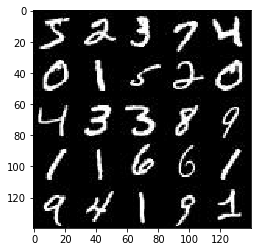

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

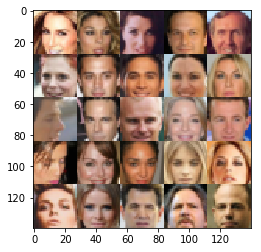

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

"""
# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
"""

"\n# Check TensorFlow Version\nassert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)\nprint('TensorFlow Version: {}'.format(tf.__version__))\n\n# Check for a GPU\nif not tf.test.gpu_device_name():\n    warnings.warn('No GPU found. Please use a GPU to train your neural network.')\nelse:\n    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))\n"

In [1]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_real')
    fake_imgs = tf.placeholder(tf.float32, [None, image_width,image_height,image_channels], name='input_fake')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_imgs, fake_imgs,inputs_z, learning_rate

In [2]:
HIDDEN_DIM = 1024
INPUT_DIM = 28 * 28 * 1
IMAGE_SHAPE = [28, 28, 1]

## Encoder

In [3]:
def encoder(images, z_dim, leaky_factor=0.2, name='encoder', reuse=False):
    """
    Create the encoder network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :leaky_factor: leaky_factor for leaky relu layer
    :return: Tensor of output vector (latent z )
    """
    with tf.variable_scope(name, reuse=reuse):

        # Flatten it
        #norm = tf.random_normal_initializer(stddev=0.01)
        x1 = tf.contrib.layers.flatten(images)
        x1 = tf.layers.dense(x1, HIDDEN_DIM)
        x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        relu1 = tf.maximum(leaky_factor * x1, x1)
        
        x2 = tf.layers.dense(relu1, HIDDEN_DIM)
        x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        relu2 = tf.maximum(leaky_factor * x2, x2)
        
        out = tf.layers.dense(relu2, z_dim)
        return out

## Decoder

In [4]:
def decoder(z, out_channel_dim, leaky_factor=0.2, name='decoder',is_train=True):
    """
    Create the decoder network
    :param images: Tensor of input z
    :param out_channel_dim: the output channel format
    :param leaky_factor: leaky_factor for leaky relu layer
    :param is_train: Boolean if it is train mode or test mode
    :return: Tensor of output vector (latent z )
    """    
    with tf.variable_scope(name, reuse= (not is_train)):
        x1 = tf.layers.dense(z, HIDDEN_DIM)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(leaky_factor * x1, x1)
        
        x2 = tf.layers.dense(relu1, HIDDEN_DIM)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(leaky_factor * x2, x2)
        
        out = tf.tanh(tf.layers.dense(relu2, INPUT_DIM))
        return tf.reshape(out, [-1] + IMAGE_SHAPE)

## Discriminator

In [5]:
def discriminator(input_z, leaky_factor=0.2, name='discriminator',reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input z
    :param leaky_factor: leaky_factor for leaky relu layer
    :param reuse: Boolean if it is train mode or test mode
    :return: tuple of (classification result, logits)
    """     
    with tf.variable_scope(name, reuse=reuse):
        
        x1 = tf.layers.dense(input_z, HIDDEN_DIM)
        x1 = tf.layers.batch_normalization(x1, training=(not reuse))
        relu1 = tf.maximum(leaky_factor * x1, x1)

        x2 = tf.layers.dense(relu1, HIDDEN_DIM)
        x2 = tf.layers.batch_normalization(x2, training=(not reuse))
        relu2 = tf.maximum(leaky_factor * x2, x2)

        logits = tf.layers.dense(x2, 1)
        out = tf.sigmoid(logits)

        return out, logits

## Corruptor

In [6]:
def corrupt(images, mask_type='inpainting',noise=False):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.get_shape().as_list()[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.1
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    if noise:
        images = tf.add(images, gnoise)
        
    if mask_type == 'inpainting':
        # inpainting 
        a, b = 2, 2
        pixFrac = np.random.beta(a,b)
        #pixFrac = 0.5
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = tf.multiply(images, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = tf.contrib.layers.flatten(images)
        #A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        #A = np.array(A, dtype=np.float32)
        #mask = np.matmul(A.transpose(), A)
        A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        mask = tf.matmul(tf.transpose(A), A)
        result = tf.matmul(flat_images, mask)
        return tf.reshape(result, [-1] + image_shape)
    else:
        return images
    
    
def corrupt_func(images, mask_type='inpainting',noise=False):
    """
    Create the discriminator network
    :param images: Tensor of input images
    :param noise: Boolean if gaussian noise will be added
    :return: Tensor of corrupted images
    """ 
    image_shape = images.shape[1:]
    x, y, z = image_shape
    length_input = x * y * z
    mu = 0.0
    sigma = 0.1
    gnoise = np.random.normal(loc=mu, scale=sigma, size=image_shape)
    if noise:
        images += gnoise
        
    if mask_type == 'inpainting':
        # inpainting 
        a, b = 2, 2
        pixFrac = np.random.beta(a,b)
        #pixFrac = 0.5
        mask = np.random.binomial(1, pixFrac, image_shape)
        result = np.multiply(images, mask)
        return result
    elif mask_type == 'compress':
        # compressive sensing
        flat_images = np.array(list(map(lambda x: x.flatten(), images)))
        
        A = np.random.normal(loc=mu, scale=sigma,size=[length_input//5, length_input])
        A = np.array(A, dtype=np.float32)
        mask = np.matmul(A.transpose(), A)
        #A = tf.random_normal([length_input // 5, length_input], name='sensing_matrix')
        #mask = tf.matmul(tf.transpose(A), A)
        #result = tf.matmul(flat_images, mask)
        result = np.array(list(map(lambda x : np.matmul(x, mask), flat_images)))
        return result.reshape(images.shape)
    else:
        return images

In [7]:
# test corrupt_func
A = corrupt_func(mnist_images, mask_type='compress', noise=False)
pyplot.imshow(helper.images_square_grid(A, 'RGB'))

NameError: name 'mnist_images' is not defined

### Loss
Implement `model_loss` to build the DAAE for training and calculate the loss.  The function should return a tuple of (discriminator loss, encoder loss, encoder-decoder loss).  Use the following functions you implemented:
- `discriminator(input_z, leaky_factor, reuse=False)`
- `decoder(z, out_channel_dim, leaky_factor, is_train=True)`
- `encoder(images, z_dim, leaky_factor, reuse=False)`

In [12]:
def model_loss(input_real, input_fake, input_z, z_dim, output_channel_dim):
    """
    Get the loss for the discriminator, encoder and decoder
    :param input_real: Images from the real dataset
    :param input_z: Z input from Laplacian distribution
    :param out_channel_dim: The number of channels in the output image
    :param M : how many iterations to sample from p(z|x)
    :return: A tuple of (discriminator loss, encoder loss, recon loss, dis_loss_sum, en_loss_sum, recon_loss_sum)
    """
    
    En = encoder(input_real, z_dim, name='en_real')
    De = decoder(En, output_channel_dim, name='decoder')
    
    recon_loss = tf.reduce_mean(tf.square(tf.subtract(De, input_real)))
    
    """
    recon_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=De_corr,
                labels=input_real))
    """
        
    d_out_real, d_logits_real = discriminator(En)  
    
    
    #corr_images = corrupt(input_real, mask_type='compress', noise=False)
    #encorr = encoder(corr_images, z_dim, name='en_fake')
    encorr = encoder(input_fake, z_dim, name='en_fake')
    reconstruction = decoder(encorr, output_channel_dim, is_train=False)
    
    en_recon_loss = tf.reduce_mean(tf.square(tf.subtract(reconstruction, input_real)))
    
    
    d_out_fake, d_logits_fake = discriminator(encorr, reuse=True)

        
    d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.zeros_like(d_out_fake)))

    d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_real,
                labels=tf.ones_like(d_out_real)))

    dis_loss = d_loss_fake + d_loss_real
    
    
    temp_en_loss_dis = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake,
                labels=tf.ones_like(d_out_fake)))
    
    temp_en_loss = tf.reduce_mean(tf.square(tf.subtract(En, encorr)))
    
    en_loss = 0.1 * temp_en_loss_dis + temp_en_loss #+ en_recon_loss
    
    
    temp_en_loss_sum = tf.summary.histogram("temp_en_loss_dis", temp_en_loss_dis)
    dis_loss_sum = tf.summary.scalar("dis_loss", dis_loss)
    recon_loss_sum = tf.summary.scalar("recon_loss", recon_loss)
    en_loss_sum = tf.summary.scalar("en_loss", en_loss)
    
    return dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,reconstruction
    
    

In [13]:
def model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1, beta2):
    """
    Get optimization operations
    :param dis_loss: Discriminator loss Tensor
    :param en_loss: encoder loss Tensor
    :param recon_loss: reconstruction loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, encoder training operation, recontraining operations)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    
    dis_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    de_vars = [var for var in t_vars if var.name.startswith('decoder')]
    en_real_vars = [var for var in t_vars if var.name.startswith('en_real')]
    en_fake_vars = [var for var in t_vars if var.name.startswith('en_fake')]
    ed_vars = de_vars + en_real_vars
    
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='decoder')):
    de_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(recon_loss, var_list=ed_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(dis_loss, var_list=dis_vars)
    
    #with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='encoder')):
    en_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1,beta2=beta2).minimize(en_loss, var_list=en_fake_vars)
    
    return d_train_opt, en_train_opt, de_train_opt





## Training

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np
import scipy.stats as stats

from scipy.stats import sem
def mean_score(scores):
    return ("##### What? The Mean score: {0:.3f} (+/-{1: .3f})").format(np.mean(scores), sem(scores))


def sample_from_dis(n_images, z_dim,dis = 'laplacian'):
    if dis == 'laplacian':
        mu = 0.0
        lam = 1.0
        return np.random.laplace(loc=mu, scale=lam, size=[n_images, z_dim])
    elif dis == 'gaussian':
        mu = 0
        lower = -1
        upper = 1
        sigma = 1 / np.sqrt(z_dim)
        sigma = 1
        z = stats.truncnorm.rvs((lower-mu)/sigma, (upper-mu)/sigma, loc=mu, scale=sigma, size=[n_images,z_dim])
        return z
    else:
        return np.random.uniform(-1, 1, size=[n_images, z_dim])


def show_decoder_output(sess, n_images, input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    example_z = sample_from_dis(n_images, z_dim, dis=None)

    samples = sess.run(
        decoder(input_z, out_channel_dim, leaky_factor=0.2, is_train = False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    
def show_endecoder_output(sess, samples, corrupt_samples, recon_samples,input_z, out_channel_dim, image_mode, distribution='laplacian'):
    """
    Show example output for the encoder-decoder
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
        
    #example_z = sample_from_dis(n_images, z_dim, dis=distribution)
    #corrupt_images = corrupt_func(sample_images, mask_type='inpainting', noise=False)
    
    #ops = [reconstruction]
    
    #samples = sess.run(
    #    ops,
    #    feed_dict={'input_fake': corrupt_images})
    
    mse = np.mean((samples - recon_samples) ** 2)
    print("######### what? the reconstruction mse is: %2.4f"  % mse)
    
    images_grid = helper.images_square_grid(recon_samples, image_mode)
    corr_grid = helper.images_square_grid(corrupt_samples, image_mode)
    
    pyplot.subplot(121)
    pyplot.imshow(corr_grid, cmap=cmap)
    
    pyplot.subplot(122)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    

## run

In [15]:
import time

checkpoint_dir = './checkpoint'
model_name = "EM_AAE.model"
mask_t = 'inpainting'

def save(saver, sess, checkpoint_dir, model_name, steps):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    saver.save(sess,os.path.join(checkpoint_dir, model_name),
                        global_step=steps)

    
def load(saver, sess, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        return True
    else:
        return False



def train(epoch_count, batch_size, z_dim, learning_rate, beta1, beta2, M, get_batches, samples, data_shape, data_image_mode):
    """
    Train the DAAE
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param beta2: The exponential decay rate for the 1st moment in the optimizer
    :param M: iterations to sample fake_z
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    num_imgs, image_width, image_height, image_channels = data_shape
    
    input_real, input_fake,input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)
    #tf.assign(lr, learning_rate)
    output_channel_dim = image_channels
    
    result = model_loss(input_real, input_fake,input_z, z_dim, output_channel_dim)
    dis_loss, en_loss, temp_en_loss_dis, recon_loss, dis_loss_sum, en_loss_sum, recon_loss_sum,reconstruction = result
    
    d_train_opt, en_train_opt, de_train_opt = model_opt(dis_loss, en_loss, recon_loss, learning_rate, beta1,beta2)
    ITER = 1 # we can train decoder more than 1 time...later~
    steps = 0
    
    recon_sum = tf.summary.merge([recon_loss_sum])
    en_sum = tf.summary.merge([en_loss_sum])
    dis_sum = tf.summary.merge([dis_loss_sum])

    saver = tf.train.Saver(max_to_keep=1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer = tf.summary.FileWriter("./logs", sess.graph)
        
        # check if already exists a model
        if load(saver, sess, checkpoint_dir):
            print("""
            We found a existing model and continue to train on it! 
            If you need a new model, delete checkpoint directory""")
        else:
            print("""NOT found a model === Initializing a new one""")
            
        temp_en_val = 1
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = sample_from_dis(batch_size, z_dim,dis = '')
 
                # Run optimizers

                # Update real_EnDecoder network
                #for i in range(ITER):
                _, summary_str = sess.run([de_train_opt, recon_sum],
                            feed_dict={ input_real: batch_images})
                writer.add_summary(summary_str, steps)
                
                
                # Update Discriminator and fake_Encoder
                
                for i in range(M):
                    
                    batch_fake = corrupt_func(batch_images, mask_type=mask_t, noise=False)
                    # Update Discriminator network    
                    if temp_en_val < 0.80:
                        _, summary_str = sess.run([d_train_opt, dis_sum],
                            feed_dict={ input_real: batch_images, input_fake:batch_fake,input_z: batch_z })
                        writer.add_summary(summary_str, steps)
                
                    # Update the fake_Encoder network
                    for j in range(ITER):
                        _, summary_str = sess.run([en_train_opt, en_sum],
                            feed_dict={input_real: batch_images, input_fake:batch_fake})
                    writer.add_summary(summary_str, steps)
               



                
                if steps % 10 == 0:
                    ops = [dis_loss, en_loss, temp_en_loss_dis, recon_loss]
                    dis_val,en_val,temp_en_val, recon_val= sess.run(ops, feed_dict={input_real:batch_images, input_z:batch_z,input_fake:batch_fake})
                    print("dis_loss: %.7f, en_loss: %.7f, temp_en_dis: %.7f recon_loss: %2.4f" % (dis_val, en_val, temp_en_val,recon_val))
                    
                if steps % 100 == 0:
                    #show_decoder_output(sess, show_n_images, input_z, output_channel_dim, data_image_mode)
                    corrupt_samples = corrupt_func(samples, mask_type=mask_t, noise=False)
                    recon_samples = sess.run(reconstruction, feed_dict={input_fake:corrupt_samples})
                    show_endecoder_output(sess, samples,corrupt_samples,recon_samples,input_z, output_channel_dim, data_image_mode)
                    
                if steps % 500 == 1:
                    save(saver, sess, checkpoint_dir, model_name, steps)
                    
                    

## Test!

(59975, 28, 28, 1)
 [*] Reading checkpoints...
NOT found a model === Initializing a new one
dis_loss: 1.6159399, en_loss: 0.5789185, temp_en_dis: 0.6547539 recon_loss: 0.4990
dis_loss: 0.5699988, en_loss: 0.8151244, temp_en_dis: 3.5615702 recon_loss: 0.2719
dis_loss: 0.6023056, en_loss: 0.8020525, temp_en_dis: 3.9066999 recon_loss: 0.1710
dis_loss: 0.5657544, en_loss: 0.7111086, temp_en_dis: 4.3451462 recon_loss: 0.1500
dis_loss: 0.5996744, en_loss: 1.9140135, temp_en_dis: 3.8334200 recon_loss: 0.1263
dis_loss: 0.6221548, en_loss: 1.5894587, temp_en_dis: 4.3418465 recon_loss: 0.1264
dis_loss: 0.6103508, en_loss: 1.7102712, temp_en_dis: 4.4167719 recon_loss: 0.1348
dis_loss: 0.6169453, en_loss: 1.4246366, temp_en_dis: 4.8861079 recon_loss: 0.1227
dis_loss: 0.7106306, en_loss: 0.8710793, temp_en_dis: 5.1701822 recon_loss: 0.1104
dis_loss: 0.6970121, en_loss: 0.7619228, temp_en_dis: 5.4429913 recon_loss: 0.1023
######### what? the reconstruction mse is: 0.0748


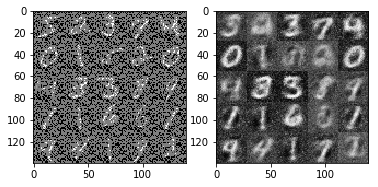

dis_loss: 0.6184060, en_loss: 3.7185924, temp_en_dis: 4.6758909 recon_loss: 0.0978
dis_loss: 0.6646870, en_loss: 7.5569892, temp_en_dis: 4.0155325 recon_loss: 0.1147
dis_loss: 0.6867127, en_loss: 1.3477471, temp_en_dis: 5.4106836 recon_loss: 0.1087
dis_loss: 0.6909911, en_loss: 1.3830523, temp_en_dis: 5.7510004 recon_loss: 0.1066
dis_loss: 0.7159238, en_loss: 2.0510180, temp_en_dis: 5.3358002 recon_loss: 0.1166
dis_loss: 0.7000874, en_loss: 1.5115447, temp_en_dis: 5.7172937 recon_loss: 0.1496
dis_loss: 0.6982421, en_loss: 1.5725987, temp_en_dis: 5.9111938 recon_loss: 0.0817
dis_loss: 0.7302472, en_loss: 1.0487270, temp_en_dis: 5.9368658 recon_loss: 0.0916
dis_loss: 0.6451637, en_loss: 1.4905504, temp_en_dis: 5.8473449 recon_loss: 0.0852
dis_loss: 0.6599413, en_loss: 1.4699069, temp_en_dis: 5.9257340 recon_loss: 0.1043
######### what? the reconstruction mse is: 0.1234


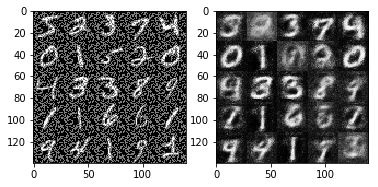

dis_loss: 0.6649811, en_loss: 1.1310816, temp_en_dis: 6.1194267 recon_loss: 0.1041
dis_loss: 0.7898521, en_loss: 2.3685794, temp_en_dis: 5.7529602 recon_loss: 0.1215
dis_loss: 0.8609403, en_loss: 3.5958922, temp_en_dis: 5.2582073 recon_loss: 0.1149
dis_loss: 0.7372270, en_loss: 6.7061410, temp_en_dis: 5.1799431 recon_loss: 0.0966
dis_loss: 0.7103188, en_loss: 3.1650791, temp_en_dis: 5.6683879 recon_loss: 0.0914
dis_loss: 0.7098140, en_loss: 3.4314020, temp_en_dis: 5.5781579 recon_loss: 0.0892
dis_loss: 0.7735208, en_loss: 0.9512814, temp_en_dis: 6.1875734 recon_loss: 0.0980
dis_loss: 0.6579913, en_loss: 1.8793292, temp_en_dis: 6.0790110 recon_loss: 0.0777
dis_loss: 0.7622834, en_loss: 1.5274413, temp_en_dis: 6.0866365 recon_loss: 0.0934
dis_loss: 0.7985905, en_loss: 1.9497595, temp_en_dis: 5.9753385 recon_loss: 0.0971
######### what? the reconstruction mse is: 0.1435


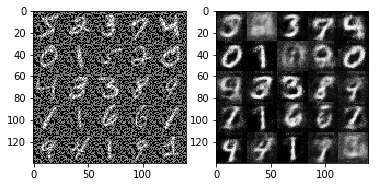

dis_loss: 0.7268966, en_loss: 1.9521319, temp_en_dis: 6.1142931 recon_loss: 0.0896
dis_loss: 0.7358570, en_loss: 9.7289867, temp_en_dis: 5.1142101 recon_loss: 0.0827
dis_loss: 0.7483510, en_loss: 1.9694426, temp_en_dis: 6.1686707 recon_loss: 0.0852
dis_loss: 0.7171500, en_loss: 1.0789319, temp_en_dis: 6.3026810 recon_loss: 0.0874
dis_loss: 0.6833332, en_loss: 0.9504025, temp_en_dis: 6.3901587 recon_loss: 0.0884
dis_loss: 0.7777762, en_loss: 1.3839111, temp_en_dis: 6.2584362 recon_loss: 0.0895
dis_loss: 0.6972846, en_loss: 1.0331600, temp_en_dis: 6.3257642 recon_loss: 0.0993
dis_loss: 0.7548252, en_loss: 0.9418561, temp_en_dis: 6.3704624 recon_loss: 0.0852
dis_loss: 0.7074614, en_loss: 4.1713700, temp_en_dis: 5.5212727 recon_loss: 0.0851
dis_loss: 0.8200438, en_loss: 0.9864792, temp_en_dis: 6.4247031 recon_loss: 0.0876
######### what? the reconstruction mse is: 0.1738


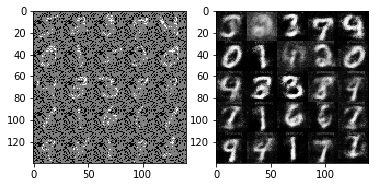

dis_loss: 0.7137617, en_loss: 17.3781147, temp_en_dis: 4.4749699 recon_loss: 0.0822
dis_loss: 0.7225764, en_loss: 10.2703056, temp_en_dis: 5.2785339 recon_loss: 0.0840
dis_loss: 0.7918588, en_loss: 1.0558290, temp_en_dis: 6.4007053 recon_loss: 0.0875
dis_loss: 0.7488098, en_loss: 1.1259710, temp_en_dis: 6.4750328 recon_loss: 0.0877
dis_loss: 0.7536511, en_loss: 2.0412736, temp_en_dis: 6.2992411 recon_loss: 0.0804
dis_loss: 0.7407613, en_loss: 1.3754418, temp_en_dis: 6.4882059 recon_loss: 0.0689
dis_loss: 0.8542568, en_loss: 2.0243223, temp_en_dis: 5.9995227 recon_loss: 0.1018
dis_loss: 0.7346892, en_loss: 2.1697154, temp_en_dis: 6.1309423 recon_loss: 0.0821
dis_loss: 0.8204763, en_loss: 1.6356659, temp_en_dis: 5.9451036 recon_loss: 0.0845
dis_loss: 0.7238167, en_loss: 1.9892901, temp_en_dis: 6.1413131 recon_loss: 0.0957
######### what? the reconstruction mse is: 0.1806


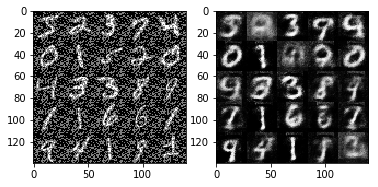

dis_loss: 0.7888680, en_loss: 2.8354592, temp_en_dis: 6.2353134 recon_loss: 0.0926
dis_loss: 0.7761299, en_loss: 1.5849278, temp_en_dis: 6.3356075 recon_loss: 0.0800
dis_loss: 0.8048176, en_loss: 1.3023620, temp_en_dis: 6.3399892 recon_loss: 0.0661
dis_loss: 0.7933978, en_loss: 1.0890681, temp_en_dis: 6.5468583 recon_loss: 0.0907
dis_loss: 0.8602361, en_loss: 1.7516093, temp_en_dis: 6.2716098 recon_loss: 0.0871
dis_loss: 0.7924659, en_loss: 13.3153648, temp_en_dis: 4.9756861 recon_loss: 0.0861
dis_loss: 0.7398871, en_loss: 1.3612325, temp_en_dis: 6.2519016 recon_loss: 0.0856
dis_loss: 0.7674636, en_loss: 1.8603251, temp_en_dis: 6.2872744 recon_loss: 0.0790
dis_loss: 0.7373703, en_loss: 1.1941240, temp_en_dis: 6.5351944 recon_loss: 0.0999
dis_loss: 0.7630321, en_loss: 2.1988616, temp_en_dis: 6.1905384 recon_loss: 0.0865
######### what? the reconstruction mse is: 0.1807


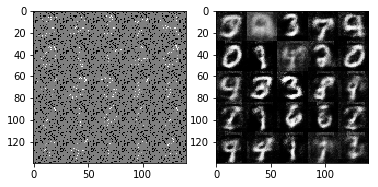

dis_loss: 0.6699024, en_loss: 2.4744620, temp_en_dis: 6.1276569 recon_loss: 0.0766
dis_loss: 0.8240195, en_loss: 1.5317310, temp_en_dis: 6.2501469 recon_loss: 0.0742
dis_loss: 0.7156829, en_loss: 1.9243016, temp_en_dis: 6.2239017 recon_loss: 0.0697
dis_loss: 0.8218328, en_loss: 1.3222848, temp_en_dis: 6.4319458 recon_loss: 0.0840
dis_loss: 0.7554868, en_loss: 1.0744874, temp_en_dis: 6.2046556 recon_loss: 0.0804
dis_loss: 0.7973881, en_loss: 2.0037193, temp_en_dis: 6.3028841 recon_loss: 0.0822
dis_loss: 0.7360564, en_loss: 2.6864445, temp_en_dis: 6.1871543 recon_loss: 0.0770
dis_loss: 0.7627262, en_loss: 1.5968351, temp_en_dis: 6.5602765 recon_loss: 0.0778
dis_loss: 0.8497647, en_loss: 1.3570563, temp_en_dis: 6.2609501 recon_loss: 0.0939
dis_loss: 0.8711654, en_loss: 2.5920632, temp_en_dis: 6.0990782 recon_loss: 0.0808
######### what? the reconstruction mse is: 0.1954


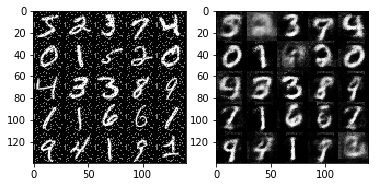

dis_loss: 0.8152023, en_loss: 1.4268413, temp_en_dis: 6.3037548 recon_loss: 0.0892
dis_loss: 0.8653454, en_loss: 1.6720068, temp_en_dis: 6.3074546 recon_loss: 0.0815
dis_loss: 0.8112175, en_loss: 0.9800810, temp_en_dis: 6.5595117 recon_loss: 0.0914
dis_loss: 0.7473944, en_loss: 1.5277731, temp_en_dis: 6.3259473 recon_loss: 0.0746
dis_loss: 0.7458315, en_loss: 1.6318481, temp_en_dis: 6.5434632 recon_loss: 0.0791
dis_loss: 0.8199992, en_loss: 2.7519221, temp_en_dis: 6.1614461 recon_loss: 0.0770
dis_loss: 0.8262452, en_loss: 1.7214961, temp_en_dis: 6.3421016 recon_loss: 0.0865
dis_loss: 0.9295322, en_loss: 2.3450947, temp_en_dis: 6.2142248 recon_loss: 0.0892
dis_loss: 0.7983398, en_loss: 1.3511548, temp_en_dis: 6.5060782 recon_loss: 0.0916
dis_loss: 0.7733848, en_loss: 2.8511131, temp_en_dis: 6.1797729 recon_loss: 0.0805
######### what? the reconstruction mse is: 0.1925


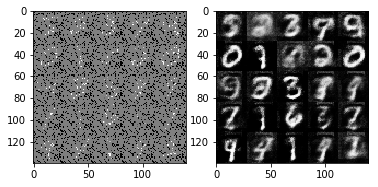

dis_loss: 0.7542123, en_loss: 1.2821689, temp_en_dis: 6.5797367 recon_loss: 0.0771
dis_loss: 0.7868102, en_loss: 1.0267303, temp_en_dis: 6.6256065 recon_loss: 0.0747
dis_loss: 0.7215421, en_loss: 1.1337242, temp_en_dis: 6.5498667 recon_loss: 0.0776
dis_loss: 0.8819686, en_loss: 1.1484208, temp_en_dis: 6.4131722 recon_loss: 0.0728
dis_loss: 0.8264550, en_loss: 1.4835331, temp_en_dis: 6.4386806 recon_loss: 0.0776
dis_loss: 0.8163542, en_loss: 1.2418658, temp_en_dis: 6.4933987 recon_loss: 0.0824
dis_loss: 0.8481407, en_loss: 2.5420461, temp_en_dis: 6.4250422 recon_loss: 0.0853
dis_loss: 0.7747541, en_loss: 1.0326676, temp_en_dis: 6.5043745 recon_loss: 0.0736
dis_loss: 0.8545811, en_loss: 1.1665101, temp_en_dis: 6.5949802 recon_loss: 0.0676
dis_loss: 0.8034979, en_loss: 1.4603157, temp_en_dis: 6.4583645 recon_loss: 0.0846
######### what? the reconstruction mse is: 0.2010


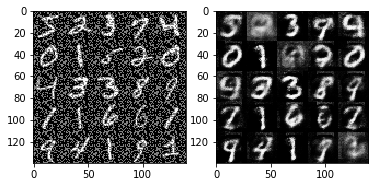

dis_loss: 0.7910529, en_loss: 1.2065651, temp_en_dis: 6.6990294 recon_loss: 0.0990
dis_loss: 0.8967687, en_loss: 1.3604555, temp_en_dis: 6.4463854 recon_loss: 0.1061
dis_loss: 0.6909086, en_loss: 1.8083212, temp_en_dis: 6.5899258 recon_loss: 0.0720
dis_loss: 0.7834101, en_loss: 1.1937797, temp_en_dis: 6.2737393 recon_loss: 0.0735
dis_loss: 0.8155741, en_loss: 1.8351529, temp_en_dis: 6.3388824 recon_loss: 0.0649
dis_loss: 0.8060964, en_loss: 1.1663527, temp_en_dis: 6.1952286 recon_loss: 0.0800
dis_loss: 0.8730512, en_loss: 1.7386658, temp_en_dis: 6.4737549 recon_loss: 0.0672
dis_loss: 0.8693119, en_loss: 1.1705132, temp_en_dis: 6.5347643 recon_loss: 0.0838
dis_loss: 0.7381955, en_loss: 1.2660146, temp_en_dis: 6.5184417 recon_loss: 0.0773
dis_loss: 0.7758178, en_loss: 1.7385471, temp_en_dis: 6.4062204 recon_loss: 0.0751
######### what? the reconstruction mse is: 0.2064


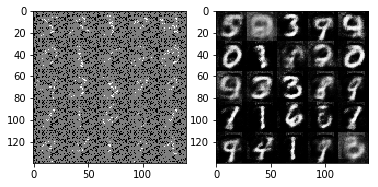

dis_loss: 0.8157082, en_loss: 1.2842573, temp_en_dis: 6.5830784 recon_loss: 0.0762
dis_loss: 0.8315935, en_loss: 1.4586854, temp_en_dis: 6.4498444 recon_loss: 0.0804
dis_loss: 0.7760552, en_loss: 10.7818089, temp_en_dis: 5.0907726 recon_loss: 0.0691
dis_loss: 0.7802041, en_loss: 0.9532851, temp_en_dis: 6.7131038 recon_loss: 0.0635
dis_loss: 0.7862985, en_loss: 1.2739428, temp_en_dis: 6.2220249 recon_loss: 0.0797
dis_loss: 0.8392877, en_loss: 1.4324006, temp_en_dis: 6.3784485 recon_loss: 0.0889
dis_loss: 0.8945171, en_loss: 1.1923889, temp_en_dis: 6.5564694 recon_loss: 0.0915
dis_loss: 0.8442180, en_loss: 2.8653970, temp_en_dis: 6.0975919 recon_loss: 0.0809
dis_loss: 0.8621603, en_loss: 1.8821692, temp_en_dis: 6.4137025 recon_loss: 0.0768
dis_loss: 0.7851659, en_loss: 1.9745190, temp_en_dis: 6.6402102 recon_loss: 0.0737
######### what? the reconstruction mse is: 0.2160


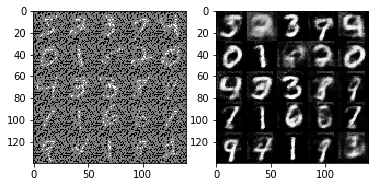

dis_loss: 0.7021169, en_loss: 2.0987854, temp_en_dis: 6.5749807 recon_loss: 0.0656
dis_loss: 0.8210502, en_loss: 7.9289060, temp_en_dis: 5.5116873 recon_loss: 0.0718
dis_loss: 0.7723395, en_loss: 1.0747176, temp_en_dis: 6.5158668 recon_loss: 0.0780
dis_loss: 0.8076854, en_loss: 1.5847958, temp_en_dis: 6.4801769 recon_loss: 0.0862
dis_loss: 0.7570513, en_loss: 0.9960494, temp_en_dis: 6.5727634 recon_loss: 0.0773
dis_loss: 0.7950479, en_loss: 1.0805106, temp_en_dis: 6.4614410 recon_loss: 0.0805
dis_loss: 0.7769657, en_loss: 2.7102945, temp_en_dis: 6.0745282 recon_loss: 0.0837
dis_loss: 0.7063768, en_loss: 1.6468382, temp_en_dis: 6.5056205 recon_loss: 0.0638
dis_loss: 0.8075183, en_loss: 4.4224944, temp_en_dis: 5.8900576 recon_loss: 0.0693
dis_loss: 0.7858070, en_loss: 2.1340294, temp_en_dis: 6.2341628 recon_loss: 0.0911
######### what? the reconstruction mse is: 0.2167


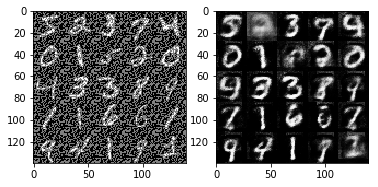

dis_loss: 0.6947972, en_loss: 0.9218882, temp_en_dis: 6.4971905 recon_loss: 0.0681
dis_loss: 0.7990217, en_loss: 1.8837860, temp_en_dis: 6.4144216 recon_loss: 0.0689
dis_loss: 0.8598945, en_loss: 1.2610754, temp_en_dis: 6.6138520 recon_loss: 0.0779
dis_loss: 0.7576113, en_loss: 1.8199948, temp_en_dis: 6.3345251 recon_loss: 0.0772
dis_loss: 0.8616897, en_loss: 2.5745244, temp_en_dis: 6.2330561 recon_loss: 0.0897
dis_loss: 0.7589201, en_loss: 2.4068897, temp_en_dis: 6.3838863 recon_loss: 0.0706
dis_loss: 0.8344851, en_loss: 1.6780795, temp_en_dis: 6.4528928 recon_loss: 0.0791
dis_loss: 0.7457020, en_loss: 0.9627624, temp_en_dis: 6.6858630 recon_loss: 0.0652
dis_loss: 0.7881638, en_loss: 1.9991710, temp_en_dis: 6.1656542 recon_loss: 0.0795
dis_loss: 0.8882195, en_loss: 1.4543183, temp_en_dis: 6.4061651 recon_loss: 0.0666
######### what? the reconstruction mse is: 0.2195


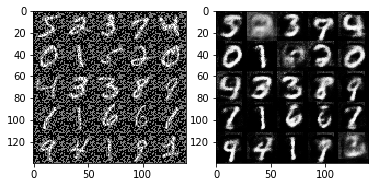

dis_loss: 0.7308539, en_loss: 1.7427793, temp_en_dis: 6.4057355 recon_loss: 0.0829
dis_loss: 0.9197509, en_loss: 3.1826458, temp_en_dis: 6.1814442 recon_loss: 0.0837
dis_loss: 0.7300811, en_loss: 5.3548946, temp_en_dis: 5.8353796 recon_loss: 0.0723
dis_loss: 0.7540452, en_loss: 1.3035815, temp_en_dis: 6.3728991 recon_loss: 0.0677
dis_loss: 0.8134120, en_loss: 2.7362206, temp_en_dis: 6.1298161 recon_loss: 0.0680
dis_loss: 0.7913554, en_loss: 1.0842602, temp_en_dis: 6.7965927 recon_loss: 0.0802
dis_loss: 0.8057705, en_loss: 0.9786940, temp_en_dis: 6.5405812 recon_loss: 0.0707
dis_loss: 0.8426990, en_loss: 0.9433799, temp_en_dis: 6.4581742 recon_loss: 0.0736
dis_loss: 0.7346818, en_loss: 1.9830813, temp_en_dis: 6.3742871 recon_loss: 0.0761
dis_loss: 0.7621974, en_loss: 0.9403300, temp_en_dis: 6.7542939 recon_loss: 0.0793
######### what? the reconstruction mse is: 0.2204


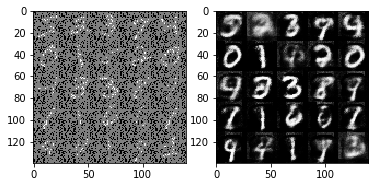

dis_loss: 0.8144195, en_loss: 1.4016969, temp_en_dis: 6.4382243 recon_loss: 0.0701
dis_loss: 0.8384073, en_loss: 0.9680709, temp_en_dis: 6.5093279 recon_loss: 0.0727
dis_loss: 0.7607744, en_loss: 1.7604904, temp_en_dis: 6.1999216 recon_loss: 0.0703
dis_loss: 0.7898453, en_loss: 1.7025149, temp_en_dis: 6.1478825 recon_loss: 0.0801
dis_loss: 0.8498850, en_loss: 1.0211726, temp_en_dis: 6.5541315 recon_loss: 0.0684
dis_loss: 0.7120511, en_loss: 1.3901441, temp_en_dis: 6.4230704 recon_loss: 0.0672
dis_loss: 0.8140486, en_loss: 1.4160476, temp_en_dis: 6.3883457 recon_loss: 0.0757
dis_loss: 0.7819938, en_loss: 1.6484978, temp_en_dis: 6.2181044 recon_loss: 0.0764
dis_loss: 0.7050967, en_loss: 1.3261176, temp_en_dis: 6.3062491 recon_loss: 0.0674
dis_loss: 0.7632135, en_loss: 1.4115518, temp_en_dis: 6.2996788 recon_loss: 0.0785
######### what? the reconstruction mse is: 0.2128


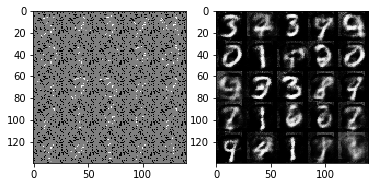

dis_loss: 0.8267940, en_loss: 1.8043853, temp_en_dis: 6.2049303 recon_loss: 0.0766
dis_loss: 0.8287064, en_loss: 1.1458998, temp_en_dis: 6.3073368 recon_loss: 0.0819
dis_loss: 0.7865656, en_loss: 1.1115861, temp_en_dis: 6.2868528 recon_loss: 0.0687
dis_loss: 0.7609316, en_loss: 1.2255926, temp_en_dis: 6.2990017 recon_loss: 0.0759
dis_loss: 0.7834072, en_loss: 2.2657118, temp_en_dis: 6.3469934 recon_loss: 0.0593
dis_loss: 0.7804801, en_loss: 2.8541119, temp_en_dis: 5.9994020 recon_loss: 0.0809
dis_loss: 0.8686905, en_loss: 1.9297745, temp_en_dis: 6.1222711 recon_loss: 0.0728
dis_loss: 0.7715666, en_loss: 2.2187104, temp_en_dis: 6.1366444 recon_loss: 0.0751
dis_loss: 0.9130719, en_loss: 2.7193944, temp_en_dis: 5.7116952 recon_loss: 0.0726
dis_loss: 0.8514225, en_loss: 1.0884155, temp_en_dis: 6.2753315 recon_loss: 0.0792
######### what? the reconstruction mse is: 0.2173


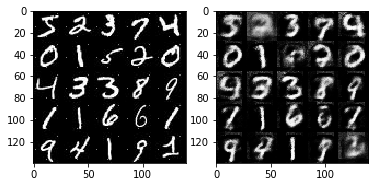

dis_loss: 0.7530769, en_loss: 2.9896066, temp_en_dis: 5.9414926 recon_loss: 0.0698
dis_loss: 0.8193840, en_loss: 0.9422005, temp_en_dis: 6.2946272 recon_loss: 0.0624
dis_loss: 0.8969917, en_loss: 1.3836277, temp_en_dis: 6.1582565 recon_loss: 0.0688
dis_loss: 0.8821336, en_loss: 2.6754172, temp_en_dis: 5.9937935 recon_loss: 0.0675
dis_loss: 0.8740137, en_loss: 1.0375844, temp_en_dis: 6.4182806 recon_loss: 0.0847
dis_loss: 0.7814330, en_loss: 1.5201786, temp_en_dis: 6.1363926 recon_loss: 0.0842
dis_loss: 0.7220036, en_loss: 2.8468843, temp_en_dis: 6.0910044 recon_loss: 0.0672
dis_loss: 0.7557556, en_loss: 1.2510012, temp_en_dis: 6.1718464 recon_loss: 0.0818
dis_loss: 0.8231779, en_loss: 2.0697527, temp_en_dis: 6.3569431 recon_loss: 0.0684
dis_loss: 0.8485664, en_loss: 2.7630067, temp_en_dis: 5.8667526 recon_loss: 0.0620
######### what? the reconstruction mse is: 0.2212


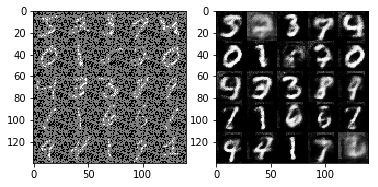

dis_loss: 0.7564476, en_loss: 1.9749656, temp_en_dis: 6.2017384 recon_loss: 0.0768
dis_loss: 0.9068286, en_loss: 1.0192585, temp_en_dis: 6.1025610 recon_loss: 0.0722
dis_loss: 0.8239406, en_loss: 1.0965551, temp_en_dis: 6.4741154 recon_loss: 0.0765
dis_loss: 0.8052515, en_loss: 4.8434939, temp_en_dis: 5.7278728 recon_loss: 0.0691
dis_loss: 0.9076779, en_loss: 0.9864737, temp_en_dis: 6.1800451 recon_loss: 0.0725
dis_loss: 0.7529709, en_loss: 1.0862098, temp_en_dis: 6.4306154 recon_loss: 0.0695
dis_loss: 0.7711084, en_loss: 1.5926505, temp_en_dis: 6.4581165 recon_loss: 0.0633
dis_loss: 0.8772658, en_loss: 1.4757997, temp_en_dis: 6.2982016 recon_loss: 0.0771
dis_loss: 0.7292302, en_loss: 1.7815726, temp_en_dis: 6.5056677 recon_loss: 0.0666
dis_loss: 0.8652158, en_loss: 2.4621563, temp_en_dis: 6.1355186 recon_loss: 0.0603
######### what? the reconstruction mse is: 0.2207


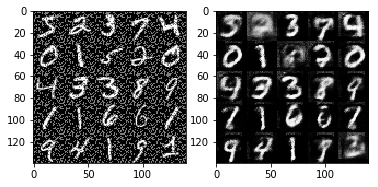

dis_loss: 0.7788224, en_loss: 3.1511705, temp_en_dis: 6.1895742 recon_loss: 0.0679
dis_loss: 0.9696123, en_loss: 1.1573114, temp_en_dis: 6.0498495 recon_loss: 0.0964
dis_loss: 0.8223531, en_loss: 1.1966048, temp_en_dis: 6.4471149 recon_loss: 0.0670
dis_loss: 0.7660226, en_loss: 1.2796828, temp_en_dis: 6.4552393 recon_loss: 0.0669
dis_loss: 0.7236102, en_loss: 1.0941308, temp_en_dis: 6.4881396 recon_loss: 0.0810
dis_loss: 0.8179607, en_loss: 1.0873163, temp_en_dis: 6.4147315 recon_loss: 0.0683
dis_loss: 0.8328261, en_loss: 0.8747659, temp_en_dis: 6.4338994 recon_loss: 0.0778
dis_loss: 0.7681605, en_loss: 1.1598039, temp_en_dis: 6.1915946 recon_loss: 0.0613
dis_loss: 0.9376114, en_loss: 0.9101318, temp_en_dis: 6.2413034 recon_loss: 0.0706
dis_loss: 0.7552198, en_loss: 2.0773928, temp_en_dis: 6.1687255 recon_loss: 0.0661
######### what? the reconstruction mse is: 0.2191


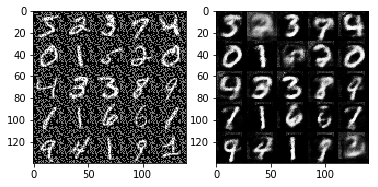

dis_loss: 0.8664270, en_loss: 1.0445020, temp_en_dis: 6.4895296 recon_loss: 0.0677
dis_loss: 0.9084044, en_loss: 1.8603985, temp_en_dis: 6.2219896 recon_loss: 0.0668
dis_loss: 0.7451914, en_loss: 1.3793170, temp_en_dis: 6.2834644 recon_loss: 0.0723
dis_loss: 0.8550197, en_loss: 1.1331702, temp_en_dis: 6.4088025 recon_loss: 0.0632
dis_loss: 0.8011206, en_loss: 0.9787487, temp_en_dis: 6.3229365 recon_loss: 0.1012
dis_loss: 0.7497116, en_loss: 0.9167129, temp_en_dis: 6.3779931 recon_loss: 0.0608
dis_loss: 0.9377484, en_loss: 1.2114788, temp_en_dis: 6.3366957 recon_loss: 0.0703
dis_loss: 0.7770277, en_loss: 1.1882027, temp_en_dis: 6.3248496 recon_loss: 0.0690
dis_loss: 0.7850975, en_loss: 1.3871359, temp_en_dis: 6.1532774 recon_loss: 0.0697
dis_loss: 0.8719830, en_loss: 3.1696975, temp_en_dis: 5.8646765 recon_loss: 0.0682
######### what? the reconstruction mse is: 0.2207


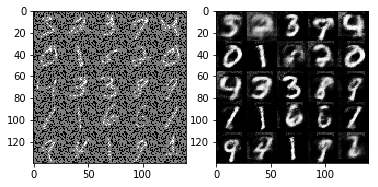

dis_loss: 0.7647346, en_loss: 1.0210662, temp_en_dis: 6.4056425 recon_loss: 0.0816
dis_loss: 0.8503310, en_loss: 1.4826419, temp_en_dis: 6.3898630 recon_loss: 0.0755
dis_loss: 0.8226997, en_loss: 1.3723911, temp_en_dis: 6.1956754 recon_loss: 0.0669
dis_loss: 0.8358727, en_loss: 1.1450081, temp_en_dis: 6.3232222 recon_loss: 0.0683
dis_loss: 0.7724491, en_loss: 1.4489341, temp_en_dis: 6.1724348 recon_loss: 0.0622
dis_loss: 0.8964187, en_loss: 8.5800762, temp_en_dis: 5.0135784 recon_loss: 0.0573
dis_loss: 0.7995353, en_loss: 3.5386386, temp_en_dis: 5.8825264 recon_loss: 0.0708
dis_loss: 0.8935355, en_loss: 1.1786759, temp_en_dis: 6.1330256 recon_loss: 0.0669
dis_loss: 0.7353820, en_loss: 1.3353887, temp_en_dis: 6.3484364 recon_loss: 0.0592
dis_loss: 0.8243706, en_loss: 2.9190683, temp_en_dis: 6.0929332 recon_loss: 0.0732
######### what? the reconstruction mse is: 0.2258


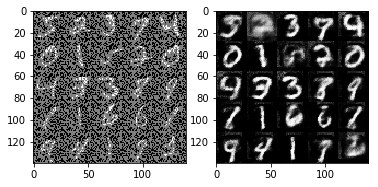

dis_loss: 0.8365788, en_loss: 1.0993047, temp_en_dis: 6.3802910 recon_loss: 0.0748
dis_loss: 0.9158741, en_loss: 0.8069320, temp_en_dis: 6.0549746 recon_loss: 0.0801
dis_loss: 0.8273109, en_loss: 1.1579282, temp_en_dis: 6.4678020 recon_loss: 0.0655
dis_loss: 0.7955192, en_loss: 1.1288512, temp_en_dis: 6.0366449 recon_loss: 0.0627
dis_loss: 0.8801280, en_loss: 11.0491514, temp_en_dis: 4.6495504 recon_loss: 0.0848
dis_loss: 0.9109014, en_loss: 1.2401814, temp_en_dis: 6.2400303 recon_loss: 0.0581
dis_loss: 0.7636998, en_loss: 1.0619435, temp_en_dis: 6.4271784 recon_loss: 0.0580
dis_loss: 0.8213827, en_loss: 1.9539082, temp_en_dis: 6.1945548 recon_loss: 0.0665
dis_loss: 0.7969987, en_loss: 0.9697160, temp_en_dis: 6.2468929 recon_loss: 0.0696
dis_loss: 0.8376535, en_loss: 0.9896723, temp_en_dis: 6.1875238 recon_loss: 0.0712
######### what? the reconstruction mse is: 0.2224


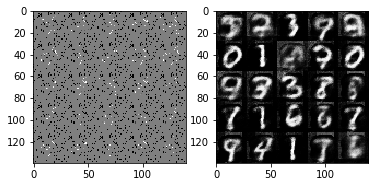

dis_loss: 0.7665498, en_loss: 0.8252033, temp_en_dis: 6.6270089 recon_loss: 0.0620
dis_loss: 0.8610595, en_loss: 1.0013726, temp_en_dis: 6.1501884 recon_loss: 0.0916
dis_loss: 0.8864828, en_loss: 2.3803976, temp_en_dis: 5.7717171 recon_loss: 0.0750
dis_loss: 0.8711090, en_loss: 1.3655217, temp_en_dis: 6.0153289 recon_loss: 0.0681
dis_loss: 0.7969158, en_loss: 1.9326096, temp_en_dis: 6.0734158 recon_loss: 0.0700
dis_loss: 0.8208066, en_loss: 0.9541515, temp_en_dis: 6.0395470 recon_loss: 0.0678
dis_loss: 0.8441102, en_loss: 1.1182029, temp_en_dis: 6.3490896 recon_loss: 0.0702
dis_loss: 0.8196858, en_loss: 2.9041553, temp_en_dis: 5.8067884 recon_loss: 0.0710
dis_loss: 0.8045592, en_loss: 12.9536734, temp_en_dis: 4.6429138 recon_loss: 0.0630
dis_loss: 0.8444219, en_loss: 0.9974968, temp_en_dis: 6.2463031 recon_loss: 0.0740
######### what? the reconstruction mse is: 0.2223


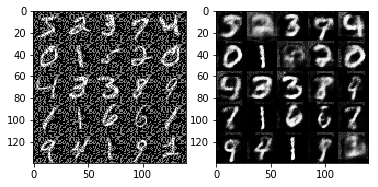

dis_loss: 0.7860056, en_loss: 1.1458715, temp_en_dis: 6.2500000 recon_loss: 0.0702
dis_loss: 0.8435826, en_loss: 0.8328927, temp_en_dis: 6.1336126 recon_loss: 0.0688
dis_loss: 0.7988293, en_loss: 3.0057011, temp_en_dis: 5.7344198 recon_loss: 0.0847
dis_loss: 0.8319660, en_loss: 1.0373341, temp_en_dis: 5.9768057 recon_loss: 0.0650
dis_loss: 0.8193531, en_loss: 1.1799469, temp_en_dis: 6.0194550 recon_loss: 0.0780
dis_loss: 0.7267413, en_loss: 1.7580042, temp_en_dis: 6.1474466 recon_loss: 0.0753
dis_loss: 0.8687289, en_loss: 1.2350767, temp_en_dis: 6.0157461 recon_loss: 0.0739
dis_loss: 0.8108602, en_loss: 4.0601306, temp_en_dis: 5.6519632 recon_loss: 0.0721
dis_loss: 0.8417422, en_loss: 2.1232281, temp_en_dis: 6.0536661 recon_loss: 0.0719
dis_loss: 0.7425372, en_loss: 1.5609076, temp_en_dis: 6.0002441 recon_loss: 0.0621
######### what? the reconstruction mse is: 0.2225


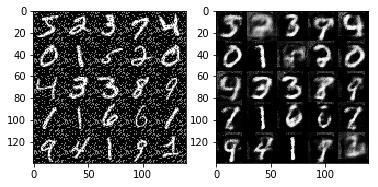

dis_loss: 0.8939780, en_loss: 1.7865520, temp_en_dis: 5.9522810 recon_loss: 0.0733
dis_loss: 0.7828789, en_loss: 0.9267124, temp_en_dis: 6.0258665 recon_loss: 0.0574
dis_loss: 0.8797061, en_loss: 1.6654196, temp_en_dis: 5.7379069 recon_loss: 0.0595
dis_loss: 0.8725063, en_loss: 4.2159867, temp_en_dis: 5.6499805 recon_loss: 0.0870
dis_loss: 0.8484126, en_loss: 1.2507862, temp_en_dis: 6.2442112 recon_loss: 0.0737
dis_loss: 0.8898335, en_loss: 0.9082310, temp_en_dis: 6.1343789 recon_loss: 0.0763
dis_loss: 0.7284197, en_loss: 1.3419356, temp_en_dis: 6.1154070 recon_loss: 0.0746
dis_loss: 0.8200282, en_loss: 0.9182826, temp_en_dis: 6.2230744 recon_loss: 0.0665
dis_loss: 0.8272843, en_loss: 1.2903023, temp_en_dis: 5.9169683 recon_loss: 0.0684
dis_loss: 0.7483701, en_loss: 0.9138789, temp_en_dis: 6.0028782 recon_loss: 0.0600
######### what? the reconstruction mse is: 0.2240


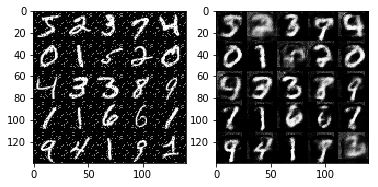

dis_loss: 0.8830094, en_loss: 0.9916838, temp_en_dis: 6.1630282 recon_loss: 0.0692
dis_loss: 0.8273127, en_loss: 1.3556812, temp_en_dis: 6.0036454 recon_loss: 0.0825
dis_loss: 0.8192297, en_loss: 0.9851523, temp_en_dis: 6.1076369 recon_loss: 0.0696
dis_loss: 0.9251086, en_loss: 0.8796114, temp_en_dis: 6.2042894 recon_loss: 0.0690
dis_loss: 0.7650365, en_loss: 1.1469703, temp_en_dis: 6.1662326 recon_loss: 0.0594
dis_loss: 0.7429298, en_loss: 1.4427760, temp_en_dis: 6.1314492 recon_loss: 0.0581
dis_loss: 0.7282178, en_loss: 0.9294800, temp_en_dis: 6.3093338 recon_loss: 0.0623
dis_loss: 0.8351734, en_loss: 1.1705114, temp_en_dis: 6.1681418 recon_loss: 0.0614
dis_loss: 0.7788492, en_loss: 2.0532069, temp_en_dis: 5.8805599 recon_loss: 0.0702
dis_loss: 0.8433275, en_loss: 0.8775151, temp_en_dis: 6.0086679 recon_loss: 0.0701
######### what? the reconstruction mse is: 0.2180


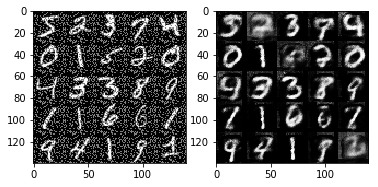

dis_loss: 0.7301823, en_loss: 0.8713536, temp_en_dis: 6.1823783 recon_loss: 0.0560
dis_loss: 0.8902913, en_loss: 0.8914480, temp_en_dis: 6.0676746 recon_loss: 0.0737
dis_loss: 0.9011112, en_loss: 1.3959103, temp_en_dis: 6.0735254 recon_loss: 0.0760
dis_loss: 0.9116032, en_loss: 2.4944098, temp_en_dis: 5.6870313 recon_loss: 0.0699
dis_loss: 0.8490480, en_loss: 2.2929003, temp_en_dis: 5.9032345 recon_loss: 0.0697
dis_loss: 0.8444725, en_loss: 1.0410185, temp_en_dis: 6.1240578 recon_loss: 0.0710
dis_loss: 0.8549212, en_loss: 0.8875973, temp_en_dis: 6.1979160 recon_loss: 0.0581
dis_loss: 0.7805704, en_loss: 1.4715607, temp_en_dis: 6.0742350 recon_loss: 0.0586
dis_loss: 0.8757292, en_loss: 1.0165104, temp_en_dis: 5.8916731 recon_loss: 0.0593
dis_loss: 0.8677931, en_loss: 1.8846152, temp_en_dis: 5.7706690 recon_loss: 0.0703
######### what? the reconstruction mse is: 0.2270


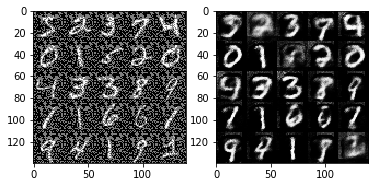

dis_loss: 0.8035172, en_loss: 0.9465637, temp_en_dis: 6.2339683 recon_loss: 0.0661
dis_loss: 0.8364603, en_loss: 1.3998222, temp_en_dis: 6.2372780 recon_loss: 0.0660
dis_loss: 0.7894232, en_loss: 5.6498179, temp_en_dis: 5.2465768 recon_loss: 0.0644
dis_loss: 0.7985266, en_loss: 4.3749194, temp_en_dis: 5.5089073 recon_loss: 0.0582
dis_loss: 0.8266811, en_loss: 1.2342589, temp_en_dis: 6.1307335 recon_loss: 0.0630
dis_loss: 0.9708276, en_loss: 1.1379662, temp_en_dis: 6.1058588 recon_loss: 0.0650
dis_loss: 0.7874435, en_loss: 0.7701334, temp_en_dis: 6.1734018 recon_loss: 0.0627
dis_loss: 0.7929271, en_loss: 4.0107627, temp_en_dis: 5.6915436 recon_loss: 0.0698
dis_loss: 0.8173175, en_loss: 1.7181399, temp_en_dis: 5.8822303 recon_loss: 0.0639
dis_loss: 0.9111685, en_loss: 1.7214330, temp_en_dis: 6.1175690 recon_loss: 0.0731
######### what? the reconstruction mse is: 0.2244


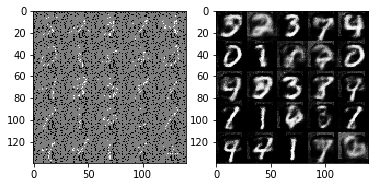

dis_loss: 0.9181376, en_loss: 0.9718186, temp_en_dis: 6.0639143 recon_loss: 0.0716
dis_loss: 0.8709019, en_loss: 0.9652953, temp_en_dis: 5.9213972 recon_loss: 0.0676
dis_loss: 0.7765535, en_loss: 1.1547538, temp_en_dis: 5.9477401 recon_loss: 0.0727
dis_loss: 0.7776303, en_loss: 1.8776008, temp_en_dis: 5.7688127 recon_loss: 0.0569
dis_loss: 0.7575687, en_loss: 0.9366478, temp_en_dis: 6.1589174 recon_loss: 0.0597
dis_loss: 0.7946649, en_loss: 0.8599269, temp_en_dis: 6.0768394 recon_loss: 0.0541
dis_loss: 0.8304375, en_loss: 11.2499027, temp_en_dis: 4.2767096 recon_loss: 0.0730
dis_loss: 0.8517129, en_loss: 1.1432934, temp_en_dis: 6.0826917 recon_loss: 0.0565
dis_loss: 0.8262952, en_loss: 0.8141008, temp_en_dis: 6.0069985 recon_loss: 0.0604
dis_loss: 0.7644689, en_loss: 1.2284858, temp_en_dis: 6.0614929 recon_loss: 0.0598
######### what? the reconstruction mse is: 0.2272


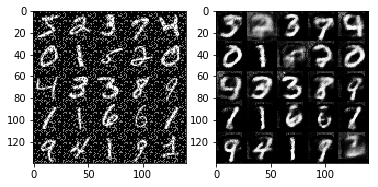

dis_loss: 0.8394874, en_loss: 0.8255725, temp_en_dis: 6.1553020 recon_loss: 0.0647
dis_loss: 0.8973038, en_loss: 0.9729248, temp_en_dis: 6.3339157 recon_loss: 0.0709
dis_loss: 0.8141552, en_loss: 1.3633497, temp_en_dis: 6.0503864 recon_loss: 0.0648
dis_loss: 0.7291238, en_loss: 1.0714189, temp_en_dis: 6.1254091 recon_loss: 0.0671
dis_loss: 0.7952855, en_loss: 1.0316699, temp_en_dis: 6.0714626 recon_loss: 0.0593
dis_loss: 0.8545157, en_loss: 0.8455844, temp_en_dis: 6.0425520 recon_loss: 0.0771
dis_loss: 0.7790379, en_loss: 1.4940319, temp_en_dis: 5.9062724 recon_loss: 0.0585
dis_loss: 0.8786641, en_loss: 3.3126993, temp_en_dis: 5.7787585 recon_loss: 0.0543
dis_loss: 0.7812002, en_loss: 0.8820015, temp_en_dis: 6.2276616 recon_loss: 0.0555
dis_loss: 0.8204854, en_loss: 0.9821596, temp_en_dis: 6.0644493 recon_loss: 0.0581
######### what? the reconstruction mse is: 0.2284


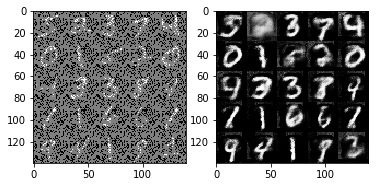

dis_loss: 0.7916219, en_loss: 0.9483145, temp_en_dis: 6.0709419 recon_loss: 0.0723
dis_loss: 0.8094527, en_loss: 5.3372331, temp_en_dis: 5.4151621 recon_loss: 0.0564
dis_loss: 0.7645671, en_loss: 2.3479764, temp_en_dis: 5.7262492 recon_loss: 0.0653
dis_loss: 0.9773154, en_loss: 2.0281389, temp_en_dis: 5.7274027 recon_loss: 0.0871
dis_loss: 0.7873622, en_loss: 1.1382306, temp_en_dis: 5.9832230 recon_loss: 0.0610
dis_loss: 0.8864433, en_loss: 3.1581852, temp_en_dis: 5.5537548 recon_loss: 0.0663
dis_loss: 0.8651201, en_loss: 0.9162328, temp_en_dis: 6.0385337 recon_loss: 0.0671
dis_loss: 0.8278620, en_loss: 2.3473520, temp_en_dis: 5.6861458 recon_loss: 0.0703
dis_loss: 0.9723646, en_loss: 1.2778140, temp_en_dis: 5.7275887 recon_loss: 0.0673
dis_loss: 0.7791608, en_loss: 1.7554872, temp_en_dis: 6.0064020 recon_loss: 0.0570
######### what? the reconstruction mse is: 0.2272


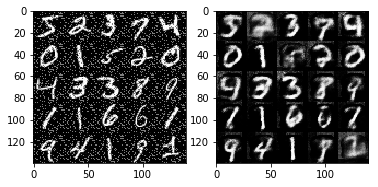

dis_loss: 0.8069553, en_loss: 2.6404226, temp_en_dis: 5.7130413 recon_loss: 0.0602
dis_loss: 0.7681377, en_loss: 1.1328787, temp_en_dis: 6.2396379 recon_loss: 0.0624
dis_loss: 0.7430582, en_loss: 1.0068096, temp_en_dis: 6.1709599 recon_loss: 0.0543
dis_loss: 0.7799262, en_loss: 1.3502300, temp_en_dis: 5.9887471 recon_loss: 0.0613
dis_loss: 0.7685370, en_loss: 0.9634856, temp_en_dis: 6.0503507 recon_loss: 0.0545
dis_loss: 0.7626423, en_loss: 1.1871265, temp_en_dis: 5.8404922 recon_loss: 0.0628
dis_loss: 0.9259950, en_loss: 0.9547058, temp_en_dis: 5.9633627 recon_loss: 0.0723
dis_loss: 0.8444264, en_loss: 0.9654859, temp_en_dis: 5.9450064 recon_loss: 0.0719
dis_loss: 0.7632613, en_loss: 0.8516033, temp_en_dis: 6.0273218 recon_loss: 0.0638
dis_loss: 0.7531265, en_loss: 2.5706692, temp_en_dis: 5.6872139 recon_loss: 0.0605
######### what? the reconstruction mse is: 0.2280


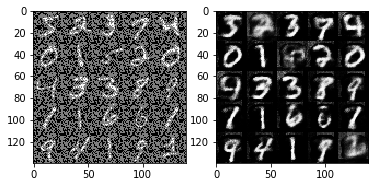

dis_loss: 0.9040378, en_loss: 1.3913006, temp_en_dis: 6.0745630 recon_loss: 0.0522
dis_loss: 0.7877181, en_loss: 0.7513963, temp_en_dis: 5.9670219 recon_loss: 0.0514
dis_loss: 0.8318232, en_loss: 0.8936689, temp_en_dis: 6.0157900 recon_loss: 0.0635
dis_loss: 0.8124215, en_loss: 0.8552921, temp_en_dis: 6.2599483 recon_loss: 0.0727
dis_loss: 0.8565508, en_loss: 1.1802286, temp_en_dis: 6.0362358 recon_loss: 0.0540
dis_loss: 0.8578542, en_loss: 0.9065207, temp_en_dis: 6.0205574 recon_loss: 0.0667
dis_loss: 0.8365692, en_loss: 1.4207542, temp_en_dis: 6.0771427 recon_loss: 0.0682
dis_loss: 0.8026785, en_loss: 18.3704720, temp_en_dis: 3.4317513 recon_loss: 0.0678
dis_loss: 0.7298998, en_loss: 1.3453841, temp_en_dis: 5.9780416 recon_loss: 0.0631
dis_loss: 0.8382989, en_loss: 0.7492086, temp_en_dis: 5.7843828 recon_loss: 0.0652
######### what? the reconstruction mse is: 0.2254


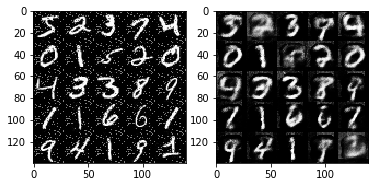

dis_loss: 0.9192520, en_loss: 1.2826799, temp_en_dis: 5.8133001 recon_loss: 0.0662
dis_loss: 0.7987528, en_loss: 1.3405328, temp_en_dis: 5.9371419 recon_loss: 0.0668
dis_loss: 0.8396547, en_loss: 1.4981434, temp_en_dis: 5.8688231 recon_loss: 0.0652
dis_loss: 0.7254370, en_loss: 1.2074592, temp_en_dis: 6.0351839 recon_loss: 0.0539
dis_loss: 0.8521158, en_loss: 5.0132856, temp_en_dis: 5.0107646 recon_loss: 0.0630
dis_loss: 0.9383051, en_loss: 0.8370334, temp_en_dis: 5.9660926 recon_loss: 0.0673
dis_loss: 0.7983066, en_loss: 11.2623272, temp_en_dis: 4.4187250 recon_loss: 0.0618
dis_loss: 0.8828934, en_loss: 1.3466570, temp_en_dis: 5.7620993 recon_loss: 0.0637
dis_loss: 0.7611956, en_loss: 3.0392721, temp_en_dis: 5.5251627 recon_loss: 0.0668
dis_loss: 0.8354471, en_loss: 2.1925468, temp_en_dis: 5.7238436 recon_loss: 0.0637
######### what? the reconstruction mse is: 0.2264


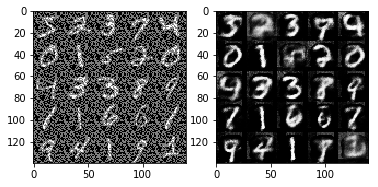

dis_loss: 0.8698952, en_loss: 1.5108545, temp_en_dis: 5.7763519 recon_loss: 0.0678
dis_loss: 0.7643303, en_loss: 0.8754450, temp_en_dis: 5.9896460 recon_loss: 0.0576
dis_loss: 0.8805327, en_loss: 1.0303214, temp_en_dis: 5.9309225 recon_loss: 0.0602
dis_loss: 0.8126978, en_loss: 2.2034805, temp_en_dis: 5.6195345 recon_loss: 0.0663
dis_loss: 0.8072618, en_loss: 1.3069205, temp_en_dis: 5.9213638 recon_loss: 0.0575
dis_loss: 0.9317822, en_loss: 0.8008623, temp_en_dis: 5.6250353 recon_loss: 0.0573
dis_loss: 0.8060123, en_loss: 0.8158865, temp_en_dis: 5.6992574 recon_loss: 0.0536
dis_loss: 0.7738238, en_loss: 0.8067138, temp_en_dis: 5.9768896 recon_loss: 0.0650
dis_loss: 0.7979128, en_loss: 1.3550608, temp_en_dis: 5.9301252 recon_loss: 0.0613
dis_loss: 0.8032786, en_loss: 0.9723424, temp_en_dis: 5.8697996 recon_loss: 0.0644
######### what? the reconstruction mse is: 0.2255


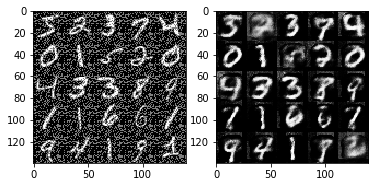

dis_loss: 0.7932072, en_loss: 1.0262735, temp_en_dis: 6.1193428 recon_loss: 0.0810
dis_loss: 0.7698452, en_loss: 1.1399450, temp_en_dis: 5.9530787 recon_loss: 0.0587
dis_loss: 0.7823268, en_loss: 0.9435599, temp_en_dis: 5.6589561 recon_loss: 0.0660
dis_loss: 0.7816202, en_loss: 1.5401905, temp_en_dis: 5.8030696 recon_loss: 0.0675
dis_loss: 0.8313960, en_loss: 2.6894221, temp_en_dis: 5.4153776 recon_loss: 0.0690
dis_loss: 0.8318157, en_loss: 0.8661621, temp_en_dis: 6.0226040 recon_loss: 0.0574
dis_loss: 0.8874142, en_loss: 1.0493463, temp_en_dis: 5.8147392 recon_loss: 0.0611
dis_loss: 0.8231844, en_loss: 0.9980802, temp_en_dis: 5.8435259 recon_loss: 0.0750
dis_loss: 0.9072022, en_loss: 0.9164748, temp_en_dis: 5.9826603 recon_loss: 0.0676
dis_loss: 0.7911705, en_loss: 1.0150356, temp_en_dis: 5.9630127 recon_loss: 0.0668
######### what? the reconstruction mse is: 0.2317


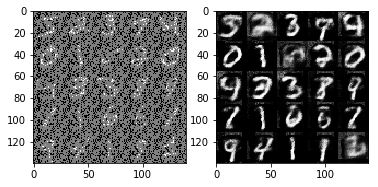

dis_loss: 0.8867527, en_loss: 0.7775460, temp_en_dis: 5.9302669 recon_loss: 0.0627
dis_loss: 0.8060486, en_loss: 1.2066193, temp_en_dis: 5.9029284 recon_loss: 0.0615
dis_loss: 0.8624797, en_loss: 0.8084850, temp_en_dis: 5.9959912 recon_loss: 0.0599
dis_loss: 0.8709339, en_loss: 0.7951738, temp_en_dis: 5.8806596 recon_loss: 0.0699
dis_loss: 0.8581113, en_loss: 1.1131344, temp_en_dis: 5.8322601 recon_loss: 0.0597
dis_loss: 0.8210412, en_loss: 7.8479147, temp_en_dis: 4.6587672 recon_loss: 0.0586
dis_loss: 0.8594586, en_loss: 1.6903764, temp_en_dis: 5.6218657 recon_loss: 0.0666
dis_loss: 0.8277019, en_loss: 0.9898984, temp_en_dis: 5.8096504 recon_loss: 0.0592
dis_loss: 0.7411798, en_loss: 3.8783565, temp_en_dis: 5.3149538 recon_loss: 0.0649
dis_loss: 0.8306317, en_loss: 1.0369692, temp_en_dis: 5.9771423 recon_loss: 0.0548
######### what? the reconstruction mse is: 0.2329


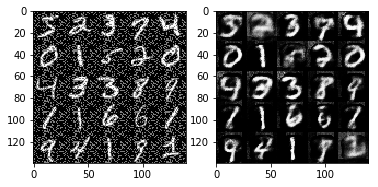

dis_loss: 0.8633693, en_loss: 1.2381320, temp_en_dis: 5.7428570 recon_loss: 0.0738
dis_loss: 0.8105118, en_loss: 0.8871382, temp_en_dis: 5.8185873 recon_loss: 0.0622


In [ ]:
batch_size = 64
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 5
z_dim = 10
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 100
sample_set = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[:25])
sample_images = next(sample_set.get_batches(25))

#sample_images = np.reshape(sample_from_dis(25, INPUT_DIM,dis = 'laplacian'), [25] + IMAGE_SHAPE)


mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg'))[25:])

print(mnist_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, mnist_dataset.get_batches, 
         sample_images, mnist_dataset.shape, mnist_dataset.image_mode)

## Faces

(202574, 28, 28, 3)
 [*] Reading checkpoints...
NOT found a model === Initializing a new one
dis_loss: 3.9600682, en_loss: 0.2602918, temp_en_dis: 0.0603001 recon_loss: 0.1556
dis_loss: 0.6609315, en_loss: 0.9375538, temp_en_dis: 3.3092904 recon_loss: 0.0919
dis_loss: 0.8456179, en_loss: 0.9318146, temp_en_dis: 3.5508258 recon_loss: 0.0787
dis_loss: 0.8871769, en_loss: 0.9206097, temp_en_dis: 3.3303070 recon_loss: 0.0848
dis_loss: 0.8591961, en_loss: 0.9570494, temp_en_dis: 3.5292053 recon_loss: 0.0852
dis_loss: 0.9189134, en_loss: 0.9332453, temp_en_dis: 3.5644801 recon_loss: 0.0668
dis_loss: 1.0830992, en_loss: 0.8898949, temp_en_dis: 3.2821732 recon_loss: 0.0680
dis_loss: 0.8397398, en_loss: 0.9401127, temp_en_dis: 3.4343047 recon_loss: 0.0587
dis_loss: 0.9886405, en_loss: 0.8977195, temp_en_dis: 3.2234027 recon_loss: 0.0600
dis_loss: 0.8887006, en_loss: 0.9122635, temp_en_dis: 3.3037753 recon_loss: 0.0552
######### what? the reconstruction mse is: 0.0593


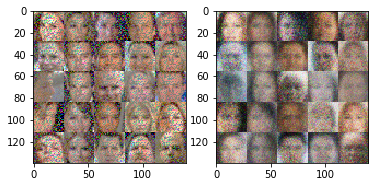

dis_loss: 0.8795070, en_loss: 0.9291641, temp_en_dis: 3.4151051 recon_loss: 0.0522
dis_loss: 0.9470062, en_loss: 0.9044546, temp_en_dis: 3.3435411 recon_loss: 0.0527
dis_loss: 1.0223174, en_loss: 0.9031685, temp_en_dis: 3.2935114 recon_loss: 0.0629
dis_loss: 0.9448521, en_loss: 0.9048872, temp_en_dis: 3.4459281 recon_loss: 0.0514
dis_loss: 0.9637688, en_loss: 0.9110182, temp_en_dis: 3.4166369 recon_loss: 0.0501
dis_loss: 0.8671284, en_loss: 0.9165490, temp_en_dis: 3.4607580 recon_loss: 0.0488
dis_loss: 1.0478630, en_loss: 0.8876740, temp_en_dis: 3.3147190 recon_loss: 0.0511
dis_loss: 0.9782572, en_loss: 0.9194275, temp_en_dis: 3.5679586 recon_loss: 0.0420
dis_loss: 1.0863668, en_loss: 0.8715082, temp_en_dis: 3.1262937 recon_loss: 0.0442
dis_loss: 1.0002069, en_loss: 0.8879004, temp_en_dis: 3.2853446 recon_loss: 0.0419
######### what? the reconstruction mse is: 0.0865


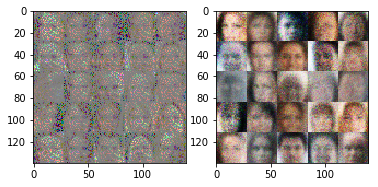

dis_loss: 1.1060513, en_loss: 0.8491828, temp_en_dis: 3.1635702 recon_loss: 0.0425
dis_loss: 1.0497657, en_loss: 0.9043359, temp_en_dis: 3.3743932 recon_loss: 0.0446
dis_loss: 1.0637997, en_loss: 0.8993841, temp_en_dis: 3.4671998 recon_loss: 0.0425
dis_loss: 1.0320634, en_loss: 0.9059755, temp_en_dis: 3.3876512 recon_loss: 0.0395
dis_loss: 1.1230507, en_loss: 0.8642875, temp_en_dis: 3.1065369 recon_loss: 0.0600
dis_loss: 1.0944240, en_loss: 0.8831871, temp_en_dis: 3.2780104 recon_loss: 0.0376
dis_loss: 1.1587087, en_loss: 0.9055543, temp_en_dis: 3.3634992 recon_loss: 0.0358
dis_loss: 1.0417964, en_loss: 0.9065704, temp_en_dis: 3.4063869 recon_loss: 0.0400
dis_loss: 1.0216081, en_loss: 0.8950148, temp_en_dis: 3.2798131 recon_loss: 0.0347
dis_loss: 1.1869133, en_loss: 0.8720577, temp_en_dis: 3.1306229 recon_loss: 0.0392
######### what? the reconstruction mse is: 0.0865


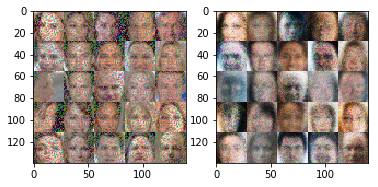

dis_loss: 1.1198655, en_loss: 0.8850302, temp_en_dis: 3.1902537 recon_loss: 0.0385
dis_loss: 1.1703429, en_loss: 0.9292830, temp_en_dis: 3.3426473 recon_loss: 0.0375
dis_loss: 0.9955916, en_loss: 0.8714961, temp_en_dis: 3.1239181 recon_loss: 0.0418
dis_loss: 1.0937679, en_loss: 0.8560746, temp_en_dis: 3.2132158 recon_loss: 0.0459
dis_loss: 1.1597475, en_loss: 0.8540556, temp_en_dis: 3.1253967 recon_loss: 0.0374
dis_loss: 1.1258751, en_loss: 0.8688090, temp_en_dis: 3.1878695 recon_loss: 0.0366
dis_loss: 1.2551140, en_loss: 0.8603458, temp_en_dis: 3.0883813 recon_loss: 0.0403
dis_loss: 1.1972566, en_loss: 0.8680518, temp_en_dis: 3.1570024 recon_loss: 0.0420
dis_loss: 1.1018732, en_loss: 0.8958675, temp_en_dis: 3.1258440 recon_loss: 0.0356
dis_loss: 1.1411712, en_loss: 0.9232163, temp_en_dis: 3.1204500 recon_loss: 0.0353
######### what? the reconstruction mse is: 0.1016


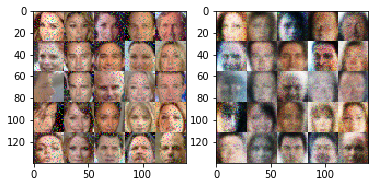

dis_loss: 1.0888999, en_loss: 0.8643974, temp_en_dis: 3.0922146 recon_loss: 0.0346
dis_loss: 1.0613071, en_loss: 0.8572462, temp_en_dis: 3.2536497 recon_loss: 0.0393
dis_loss: 1.0991472, en_loss: 0.8814232, temp_en_dis: 3.1065526 recon_loss: 0.0298
dis_loss: 1.2845365, en_loss: 0.8688735, temp_en_dis: 2.9442127 recon_loss: 0.0400
dis_loss: 1.0580838, en_loss: 0.9249192, temp_en_dis: 3.1353760 recon_loss: 0.0337
dis_loss: 1.0681756, en_loss: 0.8862796, temp_en_dis: 3.1536148 recon_loss: 0.0317
dis_loss: 1.1814014, en_loss: 0.8554333, temp_en_dis: 3.0319214 recon_loss: 0.0418
dis_loss: 0.9842826, en_loss: 0.8732666, temp_en_dis: 3.1254358 recon_loss: 0.0398
dis_loss: 1.2705897, en_loss: 0.8613209, temp_en_dis: 3.0159416 recon_loss: 0.0383
dis_loss: 1.1804124, en_loss: 0.8761614, temp_en_dis: 3.0845926 recon_loss: 0.0355
######### what? the reconstruction mse is: 0.1043


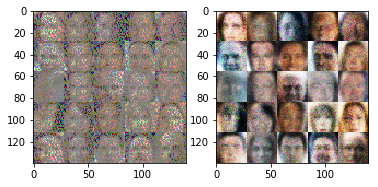

dis_loss: 1.3338853, en_loss: 0.8872891, temp_en_dis: 3.1962764 recon_loss: 0.0315
dis_loss: 1.1207540, en_loss: 0.8876277, temp_en_dis: 3.1000643 recon_loss: 0.0304
dis_loss: 1.2757974, en_loss: 0.8766069, temp_en_dis: 3.2021494 recon_loss: 0.0355
dis_loss: 1.0783560, en_loss: 0.8776742, temp_en_dis: 2.9766455 recon_loss: 0.0326
dis_loss: 1.4693502, en_loss: 0.8558518, temp_en_dis: 3.1535268 recon_loss: 0.0297
dis_loss: 1.1185472, en_loss: 0.8631217, temp_en_dis: 3.0553226 recon_loss: 0.0328
dis_loss: 1.0927073, en_loss: 0.8785065, temp_en_dis: 3.0434308 recon_loss: 0.0313
dis_loss: 1.4077917, en_loss: 0.8690735, temp_en_dis: 2.9981232 recon_loss: 0.0322
dis_loss: 1.2753537, en_loss: 0.8907296, temp_en_dis: 3.1842139 recon_loss: 0.0264
dis_loss: 1.3722786, en_loss: 0.8568044, temp_en_dis: 3.2233791 recon_loss: 0.0344
######### what? the reconstruction mse is: 0.1174


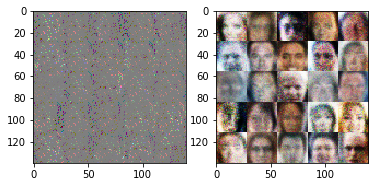

dis_loss: 1.4773076, en_loss: 0.8525270, temp_en_dis: 3.0473595 recon_loss: 0.0366
dis_loss: 1.2107410, en_loss: 0.8945184, temp_en_dis: 3.1806684 recon_loss: 0.0295
dis_loss: 1.0591377, en_loss: 0.8793489, temp_en_dis: 2.9715381 recon_loss: 0.0294
dis_loss: 1.0869806, en_loss: 0.8822452, temp_en_dis: 3.0949225 recon_loss: 0.0361
dis_loss: 1.1227531, en_loss: 0.9033344, temp_en_dis: 3.1331863 recon_loss: 0.0272
dis_loss: 1.3079574, en_loss: 0.8770653, temp_en_dis: 2.9828129 recon_loss: 0.0309
dis_loss: 1.1554272, en_loss: 0.8790072, temp_en_dis: 2.9997449 recon_loss: 0.0314
dis_loss: 1.0816462, en_loss: 0.8940886, temp_en_dis: 3.0221148 recon_loss: 0.0288
dis_loss: 1.3158367, en_loss: 0.8623769, temp_en_dis: 2.8859739 recon_loss: 0.0310
dis_loss: 1.2319100, en_loss: 0.9089908, temp_en_dis: 2.9019296 recon_loss: 0.0313
######### what? the reconstruction mse is: 0.1208


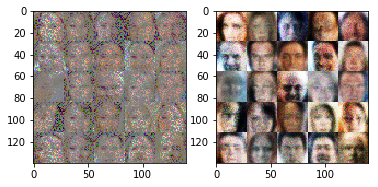

dis_loss: 1.2159232, en_loss: 0.8731776, temp_en_dis: 3.0774853 recon_loss: 0.0299
dis_loss: 1.1744637, en_loss: 0.8573773, temp_en_dis: 2.9195571 recon_loss: 0.0325
dis_loss: 1.2237864, en_loss: 0.9251635, temp_en_dis: 3.0346103 recon_loss: 0.0391
dis_loss: 1.1102544, en_loss: 0.9597141, temp_en_dis: 3.0609710 recon_loss: 0.0349
dis_loss: 1.0876443, en_loss: 0.8782364, temp_en_dis: 3.0110147 recon_loss: 0.0319
dis_loss: 1.2335451, en_loss: 0.8605930, temp_en_dis: 2.9570732 recon_loss: 0.0341
dis_loss: 1.3497274, en_loss: 0.8719556, temp_en_dis: 3.0263762 recon_loss: 0.0289
dis_loss: 1.2081786, en_loss: 0.8806056, temp_en_dis: 2.9983773 recon_loss: 0.0333
dis_loss: 1.0446264, en_loss: 0.9134030, temp_en_dis: 3.0358987 recon_loss: 0.0256
dis_loss: 1.1631173, en_loss: 0.8913974, temp_en_dis: 3.1257849 recon_loss: 0.0277
######### what? the reconstruction mse is: 0.1334


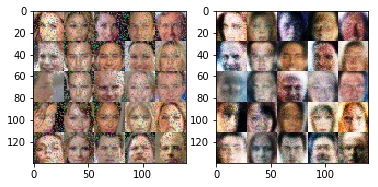

dis_loss: 1.2969074, en_loss: 0.8774052, temp_en_dis: 2.9362745 recon_loss: 0.0243
dis_loss: 1.1300514, en_loss: 0.9213753, temp_en_dis: 3.0250700 recon_loss: 0.0250
dis_loss: 1.0540468, en_loss: 0.8851984, temp_en_dis: 2.9549823 recon_loss: 0.0321
dis_loss: 1.3155534, en_loss: 0.9040946, temp_en_dis: 3.0833354 recon_loss: 0.0298
dis_loss: 1.2452887, en_loss: 0.8981630, temp_en_dis: 3.0981193 recon_loss: 0.0321
dis_loss: 1.2276009, en_loss: 0.8941076, temp_en_dis: 3.0608430 recon_loss: 0.0239
dis_loss: 1.1491706, en_loss: 0.8703707, temp_en_dis: 2.8932729 recon_loss: 0.0288
dis_loss: 1.2132764, en_loss: 0.8948666, temp_en_dis: 3.0760667 recon_loss: 0.0300
dis_loss: 1.3834240, en_loss: 0.8828560, temp_en_dis: 2.9196754 recon_loss: 0.0297
dis_loss: 0.9959111, en_loss: 0.8963523, temp_en_dis: 2.9130998 recon_loss: 0.0270
######### what? the reconstruction mse is: 0.1338


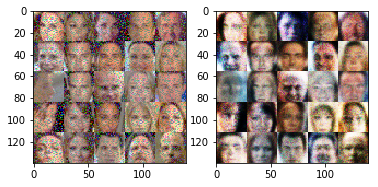

dis_loss: 1.1240461, en_loss: 0.9255248, temp_en_dis: 3.0466809 recon_loss: 0.0236
dis_loss: 1.1709889, en_loss: 0.9450384, temp_en_dis: 3.0528986 recon_loss: 0.0307
dis_loss: 1.3884720, en_loss: 0.8786730, temp_en_dis: 3.0985045 recon_loss: 0.0307
dis_loss: 1.2985027, en_loss: 0.8632307, temp_en_dis: 2.9428422 recon_loss: 0.0320
dis_loss: 1.3005735, en_loss: 0.8948586, temp_en_dis: 3.0907099 recon_loss: 0.0244
dis_loss: 1.3519157, en_loss: 0.9152220, temp_en_dis: 3.0506802 recon_loss: 0.0279
dis_loss: 1.4027593, en_loss: 0.8981528, temp_en_dis: 3.0531182 recon_loss: 0.0307
dis_loss: 1.2531902, en_loss: 0.9020315, temp_en_dis: 2.8391497 recon_loss: 0.0253
dis_loss: 1.0864050, en_loss: 0.9118590, temp_en_dis: 3.0751772 recon_loss: 0.0299
dis_loss: 1.3486489, en_loss: 0.9044929, temp_en_dis: 3.0439596 recon_loss: 0.0218
######### what? the reconstruction mse is: 0.1460


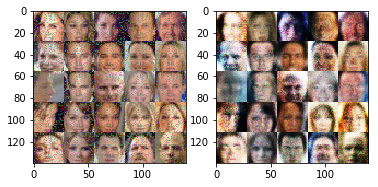

dis_loss: 1.1156201, en_loss: 0.8921652, temp_en_dis: 2.9041915 recon_loss: 0.0274
dis_loss: 1.2942958, en_loss: 0.8998397, temp_en_dis: 2.9939241 recon_loss: 0.0324
dis_loss: 1.0896295, en_loss: 0.9278581, temp_en_dis: 2.9489484 recon_loss: 0.0248
dis_loss: 1.2386955, en_loss: 0.8961772, temp_en_dis: 2.9359665 recon_loss: 0.0300
dis_loss: 1.4349387, en_loss: 0.8954309, temp_en_dis: 3.1212134 recon_loss: 0.0265
dis_loss: 1.1675647, en_loss: 0.9075509, temp_en_dis: 3.0131493 recon_loss: 0.0266
dis_loss: 1.2010412, en_loss: 0.9077132, temp_en_dis: 3.0017920 recon_loss: 0.0291
dis_loss: 1.3440453, en_loss: 0.9180239, temp_en_dis: 3.1025767 recon_loss: 0.0229
dis_loss: 1.2103024, en_loss: 0.9062582, temp_en_dis: 2.9309411 recon_loss: 0.0247
dis_loss: 1.0861505, en_loss: 0.9106253, temp_en_dis: 2.9081068 recon_loss: 0.0260
######### what? the reconstruction mse is: 0.1544


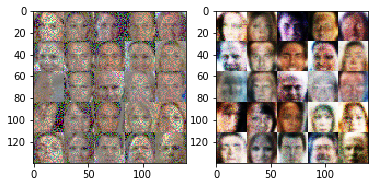

dis_loss: 1.2421310, en_loss: 0.9024926, temp_en_dis: 2.9124205 recon_loss: 0.0285
dis_loss: 1.2387360, en_loss: 0.9158304, temp_en_dis: 2.8460417 recon_loss: 0.0255
dis_loss: 1.2799277, en_loss: 0.9004262, temp_en_dis: 2.9562221 recon_loss: 0.0267
dis_loss: 1.2521482, en_loss: 0.9063436, temp_en_dis: 3.0029225 recon_loss: 0.0287
dis_loss: 1.3646595, en_loss: 0.8818326, temp_en_dis: 2.9508634 recon_loss: 0.0286
dis_loss: 1.3967164, en_loss: 0.9184524, temp_en_dis: 3.0304482 recon_loss: 0.0295
dis_loss: 1.4023204, en_loss: 0.9148855, temp_en_dis: 2.9744720 recon_loss: 0.0273
dis_loss: 1.3387498, en_loss: 0.9034417, temp_en_dis: 2.9571605 recon_loss: 0.0303
dis_loss: 1.2995585, en_loss: 0.9191771, temp_en_dis: 3.0097997 recon_loss: 0.0260
dis_loss: 1.2014599, en_loss: 0.9312732, temp_en_dis: 2.9441929 recon_loss: 0.0236
######### what? the reconstruction mse is: 0.1520


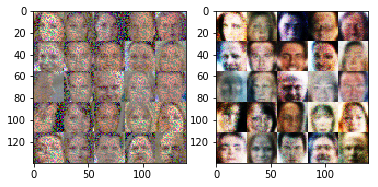

dis_loss: 1.1008502, en_loss: 0.9246740, temp_en_dis: 2.9362986 recon_loss: 0.0235
dis_loss: 1.2611164, en_loss: 0.9168668, temp_en_dis: 2.8918331 recon_loss: 0.0263
dis_loss: 1.4010165, en_loss: 0.9145529, temp_en_dis: 3.0390983 recon_loss: 0.0257
dis_loss: 1.0993937, en_loss: 0.9163572, temp_en_dis: 2.8425429 recon_loss: 0.0335
dis_loss: 1.2957150, en_loss: 0.9309509, temp_en_dis: 3.0000505 recon_loss: 0.0275
dis_loss: 1.4596174, en_loss: 0.9068515, temp_en_dis: 2.8662624 recon_loss: 0.0245
dis_loss: 1.2299979, en_loss: 0.9099245, temp_en_dis: 2.9493275 recon_loss: 0.0311
dis_loss: 1.1714339, en_loss: 0.9138822, temp_en_dis: 2.9387712 recon_loss: 0.0245
dis_loss: 1.3235726, en_loss: 0.8908839, temp_en_dis: 2.9357543 recon_loss: 0.0250
dis_loss: 1.3484674, en_loss: 0.9339503, temp_en_dis: 2.9612169 recon_loss: 0.0225
######### what? the reconstruction mse is: 0.1547


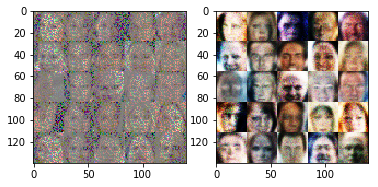

dis_loss: 1.2918484, en_loss: 0.9551652, temp_en_dis: 2.8623166 recon_loss: 0.0293
dis_loss: 1.1518239, en_loss: 0.9260611, temp_en_dis: 2.8758674 recon_loss: 0.0258
dis_loss: 1.2441677, en_loss: 0.9217556, temp_en_dis: 2.8885577 recon_loss: 0.0254
dis_loss: 1.3860178, en_loss: 0.9467195, temp_en_dis: 2.9347119 recon_loss: 0.0274
dis_loss: 1.1368821, en_loss: 0.9604161, temp_en_dis: 3.0252175 recon_loss: 0.0222
dis_loss: 1.2893600, en_loss: 0.9233224, temp_en_dis: 2.9164994 recon_loss: 0.0289
dis_loss: 1.4226885, en_loss: 0.9140525, temp_en_dis: 2.9214034 recon_loss: 0.0251
dis_loss: 1.4445156, en_loss: 0.9175348, temp_en_dis: 2.9662423 recon_loss: 0.0207
dis_loss: 1.2748275, en_loss: 0.9315917, temp_en_dis: 2.9802632 recon_loss: 0.0333
dis_loss: 1.3528184, en_loss: 0.9201105, temp_en_dis: 3.0713983 recon_loss: 0.0226
######### what? the reconstruction mse is: 0.1709


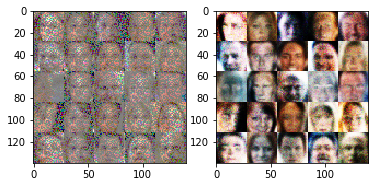

dis_loss: 1.4319363, en_loss: 0.9370822, temp_en_dis: 3.0022612 recon_loss: 0.0238
dis_loss: 1.3403209, en_loss: 0.9301999, temp_en_dis: 2.9773841 recon_loss: 0.0278
dis_loss: 1.2778401, en_loss: 0.9134311, temp_en_dis: 2.9257026 recon_loss: 0.0247
dis_loss: 1.2422894, en_loss: 0.9282127, temp_en_dis: 2.9939177 recon_loss: 0.0230
dis_loss: 1.3475354, en_loss: 0.9097027, temp_en_dis: 2.8179860 recon_loss: 0.0267
dis_loss: 1.3011074, en_loss: 0.9771832, temp_en_dis: 3.1026981 recon_loss: 0.0213
dis_loss: 1.2393292, en_loss: 0.9335669, temp_en_dis: 3.0064745 recon_loss: 0.0273
dis_loss: 1.2558322, en_loss: 0.9200330, temp_en_dis: 2.9495473 recon_loss: 0.0241
dis_loss: 1.5667638, en_loss: 0.9513761, temp_en_dis: 3.0379729 recon_loss: 0.0271
dis_loss: 1.2699933, en_loss: 0.9319093, temp_en_dis: 2.9743958 recon_loss: 0.0245
######### what? the reconstruction mse is: 0.1681


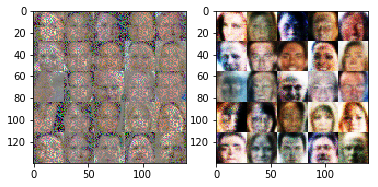

dis_loss: 1.3148038, en_loss: 0.9183642, temp_en_dis: 2.8304968 recon_loss: 0.0256
dis_loss: 1.3402728, en_loss: 0.9738627, temp_en_dis: 3.0694745 recon_loss: 0.0208
dis_loss: 1.2068305, en_loss: 0.9485699, temp_en_dis: 2.9649725 recon_loss: 0.0326
dis_loss: 1.2805933, en_loss: 0.9530028, temp_en_dis: 3.0809848 recon_loss: 0.0287
dis_loss: 1.2340310, en_loss: 0.9423154, temp_en_dis: 3.0096822 recon_loss: 0.0265
dis_loss: 1.1654383, en_loss: 0.9403048, temp_en_dis: 2.8552387 recon_loss: 0.0267
dis_loss: 1.5214386, en_loss: 0.9431551, temp_en_dis: 2.9254909 recon_loss: 0.0241
dis_loss: 1.4096358, en_loss: 0.9348411, temp_en_dis: 3.0695066 recon_loss: 0.0264
dis_loss: 1.3890146, en_loss: 0.9475949, temp_en_dis: 2.8880286 recon_loss: 0.0293
dis_loss: 1.4168817, en_loss: 0.9401466, temp_en_dis: 3.0334291 recon_loss: 0.0248
######### what? the reconstruction mse is: 0.1709


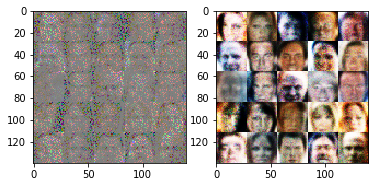

dis_loss: 1.2992824, en_loss: 0.9434361, temp_en_dis: 2.9348848 recon_loss: 0.0217
dis_loss: 1.3299015, en_loss: 1.0125837, temp_en_dis: 2.8717892 recon_loss: 0.0260
dis_loss: 1.4606218, en_loss: 0.9421769, temp_en_dis: 2.9411619 recon_loss: 0.0221
dis_loss: 1.3506337, en_loss: 0.9349045, temp_en_dis: 2.9342933 recon_loss: 0.0218
dis_loss: 1.2218724, en_loss: 1.0117322, temp_en_dis: 2.8931451 recon_loss: 0.0229
dis_loss: 1.3529323, en_loss: 0.9543938, temp_en_dis: 2.9300547 recon_loss: 0.0230
dis_loss: 1.4205023, en_loss: 0.9489341, temp_en_dis: 2.9302061 recon_loss: 0.0252
dis_loss: 1.4461541, en_loss: 1.0387431, temp_en_dis: 3.0119808 recon_loss: 0.0238
dis_loss: 1.4389653, en_loss: 0.9537516, temp_en_dis: 3.0356629 recon_loss: 0.0180
dis_loss: 1.1810381, en_loss: 0.9941902, temp_en_dis: 2.9339545 recon_loss: 0.0223
######### what? the reconstruction mse is: 0.1731


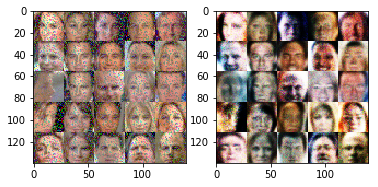

dis_loss: 1.3823292, en_loss: 0.9333941, temp_en_dis: 3.0022173 recon_loss: 0.0233
dis_loss: 1.3384409, en_loss: 0.9651415, temp_en_dis: 2.8517003 recon_loss: 0.0211
dis_loss: 1.2788670, en_loss: 0.9553722, temp_en_dis: 2.8713772 recon_loss: 0.0222
dis_loss: 1.4222101, en_loss: 0.9667757, temp_en_dis: 3.0505774 recon_loss: 0.0313
dis_loss: 1.3459063, en_loss: 0.9419832, temp_en_dis: 2.9341719 recon_loss: 0.0273
dis_loss: 1.3487799, en_loss: 0.9316241, temp_en_dis: 2.9755058 recon_loss: 0.0223
dis_loss: 1.4741699, en_loss: 0.9836961, temp_en_dis: 3.0910635 recon_loss: 0.0218
dis_loss: 1.1421552, en_loss: 0.9878961, temp_en_dis: 2.9700623 recon_loss: 0.0225
dis_loss: 1.3044374, en_loss: 0.9488572, temp_en_dis: 2.9024553 recon_loss: 0.0250
dis_loss: 1.3172083, en_loss: 0.9532504, temp_en_dis: 2.9442441 recon_loss: 0.0241
######### what? the reconstruction mse is: 0.1893


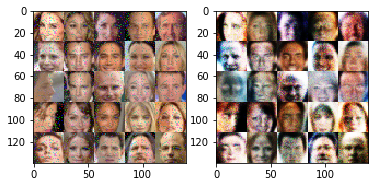

dis_loss: 1.2397910, en_loss: 0.9880626, temp_en_dis: 2.9653499 recon_loss: 0.0238
dis_loss: 1.2974595, en_loss: 0.9348097, temp_en_dis: 2.9542031 recon_loss: 0.0232
dis_loss: 1.4512576, en_loss: 0.9727666, temp_en_dis: 2.9870090 recon_loss: 0.0225
dis_loss: 1.2093383, en_loss: 0.9775246, temp_en_dis: 2.9819756 recon_loss: 0.0241
dis_loss: 1.2143769, en_loss: 0.9510158, temp_en_dis: 2.8678489 recon_loss: 0.0269
dis_loss: 1.5049379, en_loss: 0.9711893, temp_en_dis: 3.1168678 recon_loss: 0.0190
dis_loss: 1.4990021, en_loss: 0.9639746, temp_en_dis: 3.0413842 recon_loss: 0.0240
dis_loss: 1.2160448, en_loss: 1.0082139, temp_en_dis: 2.9470999 recon_loss: 0.0239
dis_loss: 1.2714710, en_loss: 0.9830089, temp_en_dis: 2.9832230 recon_loss: 0.0220
dis_loss: 1.6039242, en_loss: 0.9576402, temp_en_dis: 3.0561266 recon_loss: 0.0215
######### what? the reconstruction mse is: 0.1911


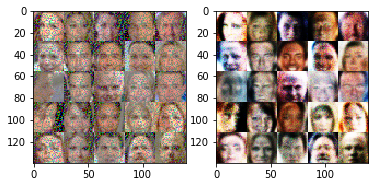

dis_loss: 1.3212734, en_loss: 0.9766892, temp_en_dis: 3.1345994 recon_loss: 0.0248
dis_loss: 1.1397431, en_loss: 1.0125574, temp_en_dis: 2.8483410 recon_loss: 0.0206
dis_loss: 1.3317755, en_loss: 0.9622797, temp_en_dis: 3.0414093 recon_loss: 0.0213
dis_loss: 1.3969103, en_loss: 0.9695699, temp_en_dis: 2.9760432 recon_loss: 0.0237
dis_loss: 1.2789091, en_loss: 1.0446064, temp_en_dis: 3.0658085 recon_loss: 0.0221
dis_loss: 1.2495806, en_loss: 0.9869708, temp_en_dis: 2.9962320 recon_loss: 0.0226
dis_loss: 1.3365270, en_loss: 0.9811859, temp_en_dis: 3.0469966 recon_loss: 0.0217
dis_loss: 1.3536344, en_loss: 1.0252165, temp_en_dis: 3.0051703 recon_loss: 0.0283
dis_loss: 1.4319110, en_loss: 0.9935080, temp_en_dis: 3.0215831 recon_loss: 0.0201
dis_loss: 1.0706213, en_loss: 0.9935857, temp_en_dis: 2.9370286 recon_loss: 0.0242
######### what? the reconstruction mse is: 0.1809


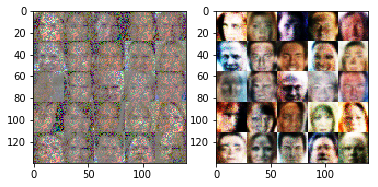

dis_loss: 1.2422470, en_loss: 0.9730818, temp_en_dis: 3.0086637 recon_loss: 0.0275
dis_loss: 1.5308174, en_loss: 0.9895828, temp_en_dis: 2.9918969 recon_loss: 0.0216
dis_loss: 1.1853104, en_loss: 0.9761074, temp_en_dis: 2.8558438 recon_loss: 0.0225
dis_loss: 1.5501224, en_loss: 0.9669592, temp_en_dis: 3.0272679 recon_loss: 0.0241
dis_loss: 1.3148425, en_loss: 0.9688820, temp_en_dis: 3.1136110 recon_loss: 0.0273
dis_loss: 1.3638700, en_loss: 0.9510865, temp_en_dis: 3.0152225 recon_loss: 0.0243
dis_loss: 1.2532402, en_loss: 0.9857759, temp_en_dis: 3.0367634 recon_loss: 0.0229
dis_loss: 1.3674517, en_loss: 1.0055439, temp_en_dis: 3.0396678 recon_loss: 0.0273
dis_loss: 1.2640417, en_loss: 1.0077333, temp_en_dis: 3.0602469 recon_loss: 0.0199
dis_loss: 1.1380407, en_loss: 1.0596998, temp_en_dis: 2.7716932 recon_loss: 0.0220
######### what? the reconstruction mse is: 0.1922


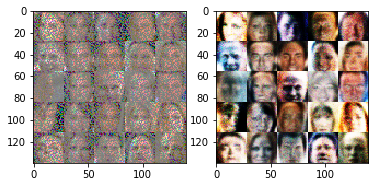

dis_loss: 1.4537020, en_loss: 0.9967332, temp_en_dis: 3.1083045 recon_loss: 0.0202


KeyboardInterrupt: 

In [44]:
batch_size = 32
learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.9
M = 5
z_dim = 1024
tf.reset_default_graph()
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
sample_set = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:25])
sample_images = next(sample_set.get_batches(25))

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[25:])
print(celeba_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, beta2, M, celeba_dataset.get_batches, 
         sample_images, celeba_dataset.shape, celeba_dataset.image_mode)


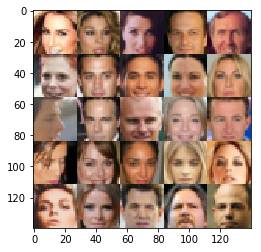

In [52]:
cmap = None
sample_images_grid = helper.images_square_grid(sample_images, celeba_dataset.image_mode)
pyplot.imshow(sample_images_grid, cmap=cmap)
pyplot.show()